# 🧭 Exploring Gazetteer Descriptions (1803–1901)

This notebook supports semantic, temporal, and linguistic analysis of enriched Scottish Gazetteer entries spanning the years **1803 to 1901**. It works with a single aggregated DataFrame `gaz_kg_concepts_df` that contains cleaned article descriptions, metadata, semantic embeddings, and cross-edition alignment for place records.

The analyses here help surface patterns in geographic language, editorial priorities, cultural shifts, and semantic changes in how places are described over time.

---

### 📘 What This Notebook Does:

- Loads the **gaz_kg_concepts_df** dataset with semantically enriched records for all editions.
- Uses **modern NLP and geospatial tools** (TF-IDF, VADER sentiment, geopy, etc.) to extract insights.
- Tracks editorial evolution of places over ~100 years across 10 editions.
- Identifies major sites of narrative change, sentiment variation, and spatial coverage.

---

### 🔍 Analyses Included (22 in Total):

1. **Yearly Article Counts** — How many articles appear in each edition.
2. **Top Place Names per Year** — Most frequently mentioned names across editions.
3. **Place Appearance Tracker** — Checks where a given place appears (or doesn’t) over time.
4. **Average Article Length (Pages & Words)** — Tracks how long articles are on average by year.
5. **Shared Articles Across Editions** — Finds place names reused across pairs of editions.
6. **Longest Article per Edition** — Identifies which article was the longest (by page count) in each year.
7. **Articles >10 Pages** — Finds long and detailed articles across the corpus.
8. **Top 30 Longest Articles Across All Editions** — Global ranking by article length.
9. **Boxplot of Word Counts per Edition** — Visualizes word count distributions across time.
10. **Most Frequent Words (Excl. Stopwords)** — Top content-bearing words per edition.
11. **Top Referenced Places (Capitalized Phrases)** — Extracts most-mentioned capitalized entities.
12. **Repeated Names by Edition** — Shows how often names are reused within a year.
13. **Alter Names Statistics** — Calculates how many entries have alternate place names.
14. **Internal References Statistics** — Tracks use of `hto:refersTo` relations.
15. **TF-IDF Keywords per Edition** — Highlights distinctive terms for each edition using TF-IDF.
16. **TF-IDF Trend for Keywords** — Plots evolution of importance for terms like "railway".
17. **Keyword Frequency Heatmap** — Measures presence of ~50 thematic terms across editions.
18. **Sentiment Analysis per Edition** — Computes average tone (positive/negative) using VADER.
19. **Sentiment of a Place Over Time** — Tracks emotional tone for a given place (e.g. "Edinburgh").
20. **Semantic Change Using Embeddings** — Calculates which places change the most semantically.
21. **Narrative Change of Cities (TF-IDF)** — Bar chart comparing linguistic change in city descriptions.
22. **Description Length Tracker** — Totals pages and word count per place across editions.

---

### 📂 Dataset

- Source: Aggregated output from the `MappingChange` pipeline (https://github.com/francesNLP/MappingChange).
- Fields include volume metadata, structured URIs, cleaned descriptions, references, and vector embeddings.
- Aligned with the [Heritage Textual Ontology (HTO)](https://w3id.org/hto).
- Dataframe available to download here: [`gaz_kg_concepts_df`](https://drive.google.com/file/d/1EyG_Jm5so6bGL6is9Br8eDs5gVutKdQX/view?usp=share_link)

The gaz_kg_concepts_df contanins the the following gazetteers:

* 1803: Gazetteer of Scotland -- 1 volume
* 1806: Gazetteer of Scotland: containing a particular and concise description of the counties, parishes, islands, cities with maps -- 1 volume
*1825: Gazetteer of Scotland: arranged under the various descriptions of counties, parishes, islands -- 1 volume
* 1838: Gazetteer of Scotland with plates and maps -- 2 volumes
* 1842: Topographical, statistical, and historical gazetteer of Scotland  -- 2 volumes
* 1846: Topographical dictionary of Scotland  -- 2 volumes
* 1868: Imperial gazetteer of Scotland; or Dictionary of Scottish topography, compiled from the most recent au- thorities, and forming a complete body of Scottish geography, physical, statistical, and historical -- 2 volumes
* 1882: Gazetteer of Scotland -- 1 volume
* 1884: Ordnance gazetteer of Scotland -- 6 volumes
* 1901: Ordnance gazetteer of Scotland -- 1 volume


This notebook serves as an **exploratory companion** to the MappingChange  project, offering rich entry points for temporal analysis, place-focused storytelling, and historical semantic drift.




## Import libraries

In [1]:
import pandas as pd
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import ast

from collections import Counter
from collections import defaultdict

import nltk
from nltk.corpus import stopwords

# Download stopwords once
nltk.download('stopwords')

# Set of English stopwords
stop_words = set(stopwords.words('english'))

import spacy
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Gazetteer Metadata: `gaz_kg_concepts_df`

The [`gaz_kg_concepts_df`](https://drive.google.com/file/d/1EyG_Jm5so6bGL6is9Br8eDs5gVutKdQX/view?usp=share_link) DataFrame contains semantically enriched metadata for historical Scottish gazetteer articles spanning from 1803 to 1901. It is produced as part of the [MappingChange project](https://github.com/francesNLP/MappingChange/tree/main), and aligned with the [Heritage Textual Ontology (HTO)](https://w3id.org/hto). The dataset is approximately 530MB in size and supports article-level, semantic, and temporal analysis of place descriptions across multiple volumes.

### 🔍 Overview of Key Fields

#### 🗂️ General Metadata
- `series_uri`: URI identifying the gazetteer series to which the volume belongs  
- `series_num`: Identifier grouping related volumes (e.g., all 1882 volumes)  
- `vol_num`: Volume number within the series  
- `vol_title`: Full title of the volume  
- `print_location`: Location of publication (typically a city)  
- `year_published`: Year the volume was published  
- `genre`: Edition or volume classification (may be numeric or categorical)

#### 📌 Article-Level Identifiers
- `record_uri`: Unique URI for each place article (HTO `LocationRecord`)  
- `record_name`: Main place name associated with the article  
- `description`: Cleaned OCR text describing the place  
- `description_uri`: URI for the original text segment (HTO `OriginalDescription`)

#### 📖 Structural Information
- `start_page_num`: Page number where the article begins  
- `end_page_num`: Page number where the article ends

#### 🔁 Semantic Links and Enrichment
- `alter_names`: List of alternative or redirected names (e.g., aliases, disambiguations)  
- `references`: List of URIs pointing to other articles (internal links using `hto:refersTo`)  
- `concept_uri`: URI linking the article to a semantic concept (e.g., standardized location or class)  
- `embedding`: Vector representation of the article description (e.g., for clustering or semantic search)

---

This DataFrame is designed to facilitate advanced exploration and comparative analysis of how places were described across time in Scotland. It integrates textual structure, linked data, and embeddings, enabling powerful downstream tasks in digital humanities and historical geography.




In [2]:
gaz_kg_concepts_df = pd.read_json("gaz_kg_concepts_df", orient="index")
gaz_kg_concepts_df.loc[gaz_kg_concepts_df["year_published"] == 1883, "year_published"] = 1884


In [3]:
gaz_kg_concepts_df.iloc[0]

,0
series_uri,https://w3id.org/hto/Series/9931344573804340
vol_num,1
vol_title,gazetteer of Scotland: containing a particular...
genre,0.0
print_location,Edinburgh
year_published,1806
series_num,6
record_uri,https://w3id.org/hto/LocationRecord/9931344573...
description,a thriving manufacturing village in the parish...
description_uri,https://w3id.org/hto/OriginalDescription/99313...


In [4]:
gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == 1882]

,series_uri,vol_num,vol_title,genre,print_location,year_published,series_num,record_uri,description,description_uri,record_name,start_page_num,end_page_num,alter_names,references,embedding,concept_uri
2,https://w3id.org/hto/Series/9933057493804340,1,Gazetteer of Scotland 1882,0.0,Edinburgh,1882,2,https://w3id.org/hto/LocationRecord/9933057493...,"KIRK-OF-FIELD, extinct collegiate church of 15...",https://w3id.org/hto/OriginalDescription/99330...,KIRKOFFIELD,289,289,[],[],"[0.0031926739, 0.0030073798, 0.0208417624, 0.0...",https://w3id.org/hto/Concept/gaz9211170934_1
20,https://w3id.org/hto/Series/9933057493804340,1,Gazetteer of Scotland 1882,0.0,Edinburgh,1882,2,https://w3id.org/hto/LocationRecord/9933057493...,village and parish on east border of Dumfriess...,https://w3id.org/hto/OriginalDescription/99330...,CANONBIE,84,84,[],[],"[-0.0456876829, -0.0980401561, 0.0036186099, 0...",https://w3id.org/hto/Concept/gaz6810607324_2
26,https://w3id.org/hto/Series/9933057493804340,1,Gazetteer of Scotland 1882,0.0,Edinburgh,1882,2,https://w3id.org/hto/LocationRecord/9933057493...,"ARMIT, affluent of G-ala water, at 5 miles nor...",https://w3id.org/hto/OriginalDescription/99330...,ARMIT,30,30,[],[],"[-0.02656883, -0.0813431069, -0.01413705670000...",https://w3id.org/hto/Concept/gaz6252672811_1
27,https://w3id.org/hto/Series/9933057493804340,1,Gazetteer of Scotland 1882,0.0,Edinburgh,1882,2,https://w3id.org/hto/LocationRecord/9933057493...,"INNISFRAOCH, rocky islet, with ruined old cast...",https://w3id.org/hto/OriginalDescription/99330...,INNISFRAOCH,250,250,[],[],"[-0.009861215900000001, -0.08831851930000001, ...",https://w3id.org/hto/Concept/gaz7546282200_1
44,https://w3id.org/hto/Series/9933057493804340,1,Gazetteer of Scotland 1882,0.0,Edinburgh,1882,2,https://w3id.org/hto/LocationRecord/9933057493...,"seat, 1J mile north of Airdrie, Lanarkshire.",https://w3id.org/hto/OriginalDescription/99330...,ROCHSOLES,400,400,[],[],"[-0.035049051000000005, -0.0651606768, 0.01502...",https://w3id.org/hto/Concept/gaz7287793292_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45618,https://w3id.org/hto/Series/9933057493804340,1,Gazetteer of Scotland 1882,0.0,Edinburgh,1882,2,https://w3id.org/hto/LocationRecord/9933057493...,"MASSAN, affluent of the Eachaig in Dunoon pari...",https://w3id.org/hto/OriginalDescription/99330...,MASSAN,332,332,[],[],"[-0.0318551175, 0.0147752976, 0.0170094781, 0....",https://w3id.org/hto/Concept/gaz3580687588_1
45621,https://w3id.org/hto/Series/9933057493804340,1,Gazetteer of Scotland 1882,0.0,Edinburgh,1882,2,https://w3id.org/hto/LocationRecord/9933057493...,"bay, ancient burying-ground, and ruins of old ...",https://w3id.org/hto/OriginalDescription/99330...,WICK,478,478,[],[],"[-0.011564659000000001, -0.0470975749, -0.0121...",https://w3id.org/hto/Concept/gaz8387404150_3
45628,https://w3id.org/hto/Series/9933057493804340,1,Gazetteer of Scotland 1882,0.0,Edinburgh,1882,2,https://w3id.org/hto/LocationRecord/9933057493...,"DUNTREATH, ancient strong castellated mansion,...",https://w3id.org/hto/OriginalDescription/99330...,DUNTREATH,160,160,[],[],"[-0.028953649100000003, -0.0157453958, 0.00112...",https://w3id.org/hto/Concept/gaz6923350212_2
45636,https://w3id.org/hto/Series/9933057493804340,1,Gazetteer of Scotland 1882,0.0,Edinburgh,1882,2,https://w3id.org/hto/LocationRecord/9933057493...,"MANGERTON, old tower, once a stronghold of 'Ki...",https://w3id.org/hto/OriginalDescription/99330...,MANGERTON,329,329,[],[],"[0.013369929000000001, -0.0039835088000000005,...",https://w3id.org/hto/Concept/gaz680496429_2


In [5]:
print(gaz_kg_concepts_df.columns.tolist())


['series_uri', 'vol_num', 'vol_title', 'genre', 'print_location', 'year_published', 'series_num', 'record_uri', 'description', 'description_uri', 'record_name', 'start_page_num', 'end_page_num', 'alter_names', 'references', 'embedding', 'concept_uri']


## Dataframe Columns

## 1. Compare article counts per edition

In [6]:
for year in sorted(gaz_kg_concepts_df['year_published'].unique()):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df['year_published'] == year]
    print(f"📘 {year}: {len(df):,} articles")



📘 1803: 1,955 articles
📘 1806: 2,468 articles
📘 1825: 2,141 articles
📘 1838: 1,958 articles
📘 1842: 2,938 articles
📘 1846: 1,990 articles
📘 1868: 6,382 articles
📘 1882: 7,297 articles
📘 1884: 9,115 articles
📘 1901: 9,407 articles


## 1.b Count the number of pages per edition

In [13]:
# Step 1: Compute article length (end - start + 1)
gaz_kg_concepts_df = gaz_kg_concepts_df.copy()
gaz_kg_concepts_df["article_length_pages"] = (
    gaz_kg_concepts_df["end_page_num"] - gaz_kg_concepts_df["start_page_num"] + 1
)

# Step 2: Total number of pages per edition = sum of all article page lengths
pages_per_edition = (
    gaz_kg_concepts_df.groupby("year_published")["article_length_pages"]
    .sum()
    .reset_index()
    .rename(columns={"year_published": "Edition", "article_length_pages": "Total Pages"})
    .sort_values(by="Edition")
)

# Step 3: Print result
print("📄 Estimated Total Pages per Edition (based on article spans):\n")
print(pages_per_edition.to_string(index=False))





📄 Estimated Total Pages per Edition (based on article spans):

 Edition  Total Pages
    1803         2121
    1806         2626
    1825         2210
    1838         2781
    1842         3791
    1846         2824
    1868         7298
    1882         7434
    1884        10261
    1901        10538


## 2. Compare most common place names

This will help identify which names are common across editions.

In [ ]:
def get_top_names(df, top_n=15):
    return Counter(df['record_name']).most_common(top_n)

top_names = {}

for year in sorted(gaz_kg_concepts_df['year_published'].unique()):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df['year_published'] == year]
    top_names[year] = get_top_names(df)

for year, names in top_names.items():
    print(f"\n🏷️ Top place names in {year}:")
    for name, count in names:
        print(f" - {name}: {count}")




🏷️ Top place names in 1803:
 - URR OR ORR: 3
 - FLADDA: 3
 - SOAY: 3
 - LESLIE: 2
 - LESMAHAGGE: 2
 - SOLWAY FRITH OR BOONESS WATH: 2
 - JEDBURGH: 2
 - BARVAS: 2
 - LOGIE: 2
 - KILMALCOLM: 2
 - LATHERON: 2
 - SCALPA: 2
 - LUCE NEW: 2
 - STITCHEL AND HUME: 2
 - KINTAIL: 2

🏷️ Top place names in 1806:
 - CARRON: 4
 - NEWTON: 4
 - KINNAIRD: 3
 - STENNESS: 3
 - FLADDA: 3
 - URR OR ORR: 3
 - STRATHAVEN: 3
 - FARA: 3
 - SOAY: 3
 - LUNAN: 3
 - ARDOCH: 2
 - CROSS: 2
 - ATHOL: 2
 - KINCARDINE: 2
 - SCALPA: 2

🏷️ Top place names in 1825:
 - DEER: 3
 - ARDOCH: 3
 - FARA: 3
 - BRORA: 3
 - GREENHOLM: 3
 - RONA: 3
 - AVEN: 3
 - ESK NORTH: 3
 - FLADDA: 3
 - PRESTON: 3
 - KIRKMICHAEL: 3
 - LESLIE: 3
 - CALDER: 3
 - BERVIE: 3
 - NEWTON: 3

🏷️ Top place names in 1838:
 - CARRON: 5
 - NEWBURGH: 4
 - KIRKMICHAEL: 4
 - NEWTON: 4
 - DALRY: 4
 - KILMUIR: 4
 - LUCE OLD: 3
 - CASTLETOWN: 3
 - MORVEN: 3
 - HAWICK: 3
 - KINCARDINE: 3
 - LEVEN: 3
 - LONGLOCH: 3
 - PRESTON: 3
 - AVEN OR AVON: 3

🏷️ Top place name

##  3. Track a place across editions

In [ ]:
place_to_track = "EDINBURGH"

for year in sorted(gaz_kg_concepts_df['year_published'].unique()):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df['year_published'] == year]
    matches = df[df["record_name"] == place_to_track]

    if not matches.empty:
        print(f"\n📍 {place_to_track} in {year} ({len(matches)} entries):")
        for _, row in matches.iterrows():
            print(f" - Pages: {row['start_page_num']}–{row['end_page_num']}")
            print(f" - First 300 chars: {row['description'][:300]}...\n")
    else:
        print(f"\n❌ {place_to_track} not found in {year}")




📍 EDINBURGH in 1803 (1 entries):
 - Pages: 188–192
 - First 300 chars: t>e metropolitan city of Scotland, and the county town of Mid-Lothian, to which county it often gives its name. It lies in 55°57' N. latitude, and 3* 14' W. longitude from London ; it formerly was much confined in its limits, consisting chiefly of what is now termed the Old Town ; but its extent has...


📍 EDINBURGH in 1806 (1 entries):
 - Pages: 215–231
 - First 300 chars: the metropolis of Scotland, and the county town of Mid-Lothian, to which county it often gives its name, lies in 55°57' N. latitude, and 3°14' W. longitude from London. It stands in the northern part of the county, about two miles S. from the Frith of Forth. The situation of the city is elevated, an...


📍 EDINBURGH in 1825 (1 entries):
 - Pages: 98–103
 - First 300 chars: the Metropolis of Scotland, is situated in the northern part of the County of Edinburgh or Mid-Lothian ; nearly a mile and a half south of the Frith of Forth, and about the sa

## 4. Compare average article length

📏 1803: 1.08 pages/article | 182.89 words/article
📏 1806: 1.06 pages/article | 142.39 words/article
📏 1825: 1.03 pages/article | 77.07 words/article
📏 1838: 1.42 pages/article | 515.29 words/article
📏 1842: 1.29 pages/article | 404.09 words/article
📏 1846: 1.42 pages/article | 626.77 words/article
📏 1868: 1.14 pages/article | 242.85 words/article
📏 1882: 1.02 pages/article | 40.88 words/article
📏 1884: 1.13 pages/article | 213.02 words/article
📏 1901: 1.12 pages/article | 219.89 words/article


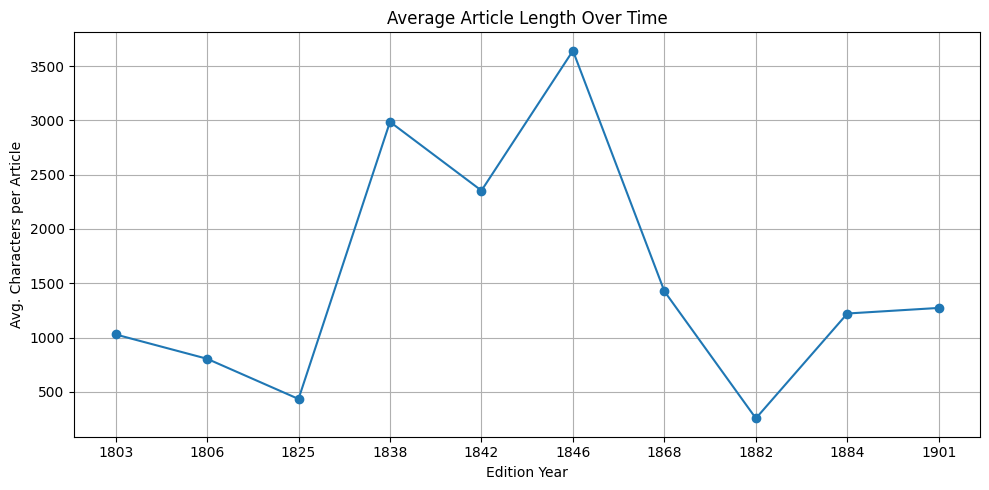

In [ ]:
# Function to compute statistics for a given subset
def article_stats(df):
    df = df.copy()
    df["article_length_pages"] = df["end_page_num"] - df["start_page_num"] + 1
    df["word_count"] = df["description"].apply(lambda x: len(str(x).split()))
    return {
        "avg_pages": df["article_length_pages"].mean(),
        "avg_words": df["word_count"].mean(),
    }

# Collect stats per year
stats_list = []
for year in sorted(gaz_kg_concepts_df['year_published'].unique()):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df['year_published'] == year]
    stats = article_stats(df)
    stats_list.append({
        "year": year,
        "avg_pages": stats["avg_pages"],
        "avg_words": stats["avg_words"]
    })
    print(f"📏 {year}: {stats['avg_pages']:.2f} pages/article | {stats['avg_words']:.2f} words/article")

# Build a dictionary of DataFrames for each edition
dfs = {
    str(year): gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]
    for year in sorted(gaz_kg_concepts_df["year_published"].unique())
}

# Calculate average character length of descriptions per edition
avg_lengths = {
    year: df["description"].dropna().astype(str).str.len().mean()
    for year, df in dfs.items()
}

# Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(list(avg_lengths.keys()), list(avg_lengths.values()), marker="o")
plt.title("Average Article Length Over Time")
plt.xlabel("Edition Year")
plt.ylabel("Avg. Characters per Article")
plt.grid(True)
plt.tight_layout()
plt.show()



# 5. Check how many articles are repeated across editions

In [ ]:
# Build a dictionary of place names per year
names_dict = {
    year: set(gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]["record_name"])
    for year in sorted(gaz_kg_concepts_df["year_published"].unique())
}

# Compare common entries between specific years
common_1803_1838 = names_dict[1803].intersection(names_dict[1838])
print(f"🔁 Common articles between 1803 and 1838: {len(common_1803_1838)}")
print(sorted(list(common_1803_1838))[:10])  # Show examples

common_1838_1846 = names_dict[1838].intersection(names_dict[1846])
print(f"🔁 Common articles between 1838 and 1846: {len(common_1838_1846)}")
print(sorted(list(common_1838_1846))[:10])  # Show examples



🔁 Common articles between 1803 and 1838: 809
['ABBOTRULE', 'ABDIE', 'ABERCORN', 'ABERDALGY', 'ABERDEEN', 'ABERDEENSHIRE', 'ABERDOUR', 'ABERFELDIE', 'ABERLADY', 'ABERLEMNO']
🔁 Common articles between 1838 and 1846: 662
['ABDIE', 'ABERCORN', 'ABERDEEN', 'ABERDEENSHIRE', 'ABERDOUR', 'ABERLADY', 'ABERLEMNO', 'ABERLOUR', 'ABERNETHY', 'ABERNYTE']


## 6. Compare Longest Article in Each Edition

<ipython-input-44-abdb2c50eece>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


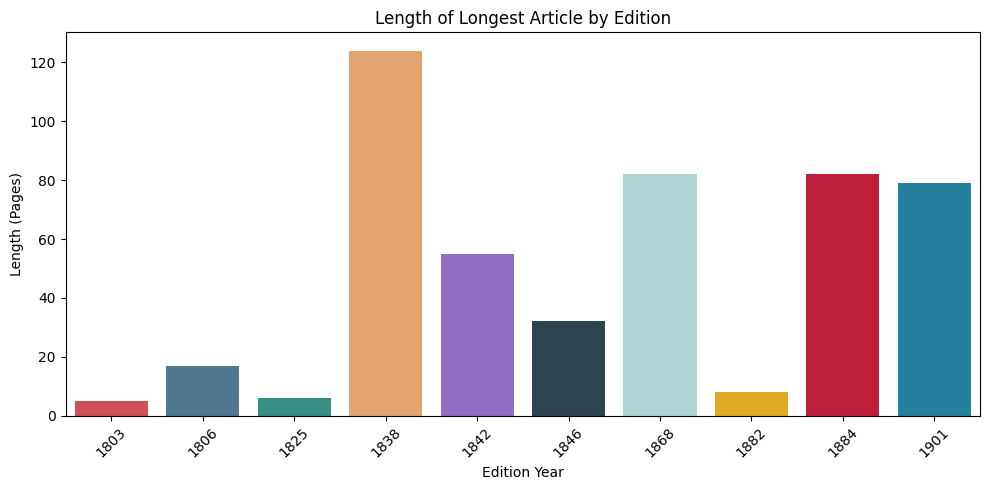

In [ ]:
# Compute longest article per edition
longest_articles = []

for year in sorted(gaz_kg_concepts_df["year_published"].unique()):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year].copy()
    df["article_length_pages"] = df["end_page_num"] - df["start_page_num"] + 1
    longest = df.loc[df["article_length_pages"].idxmax()]
    longest_articles.append({
        "edition": year,
        "record_name": longest["record_name"],
        "length": longest["article_length_pages"]
    })

# Create DataFrame for plotting
longest_df = pd.DataFrame(longest_articles)

# Ensure consistent edition order (matches the row order)
edition_order = longest_df["edition"].tolist()  # or use .drop_duplicates() if needed

# Custom 10-color palette
custom_palette = sns.color_palette([
    "#E63946",  # red
    "#457B9D",  # blue
    "#2A9D8F",  # teal
    "#F4A261",  # orange
    "#8D5FD3",  # purple
    "#264653",  # dark slate
    "#A8DADC",  # light teal
    "#FFB703",  # golden yellow
    "#D90429",  # crimson
    "#118AB2"   # deep cyan
])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=longest_df,
    x="edition",
    y="length",
    palette=custom_palette,
    order=edition_order
)
plt.title("Length of Longest Article by Edition")
plt.xlabel("Edition Year")
plt.ylabel("Length (Pages)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Next code shows all articles longer than a threshold (e.g., 10 pages), grouped by edition. This gives a clearer picture of multiple long articles

<ipython-input-45-e3d84a896b7c>:38: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(data=long_df, x="length", y="record_name", hue="edition", dodge=True, palette=custom_palette)


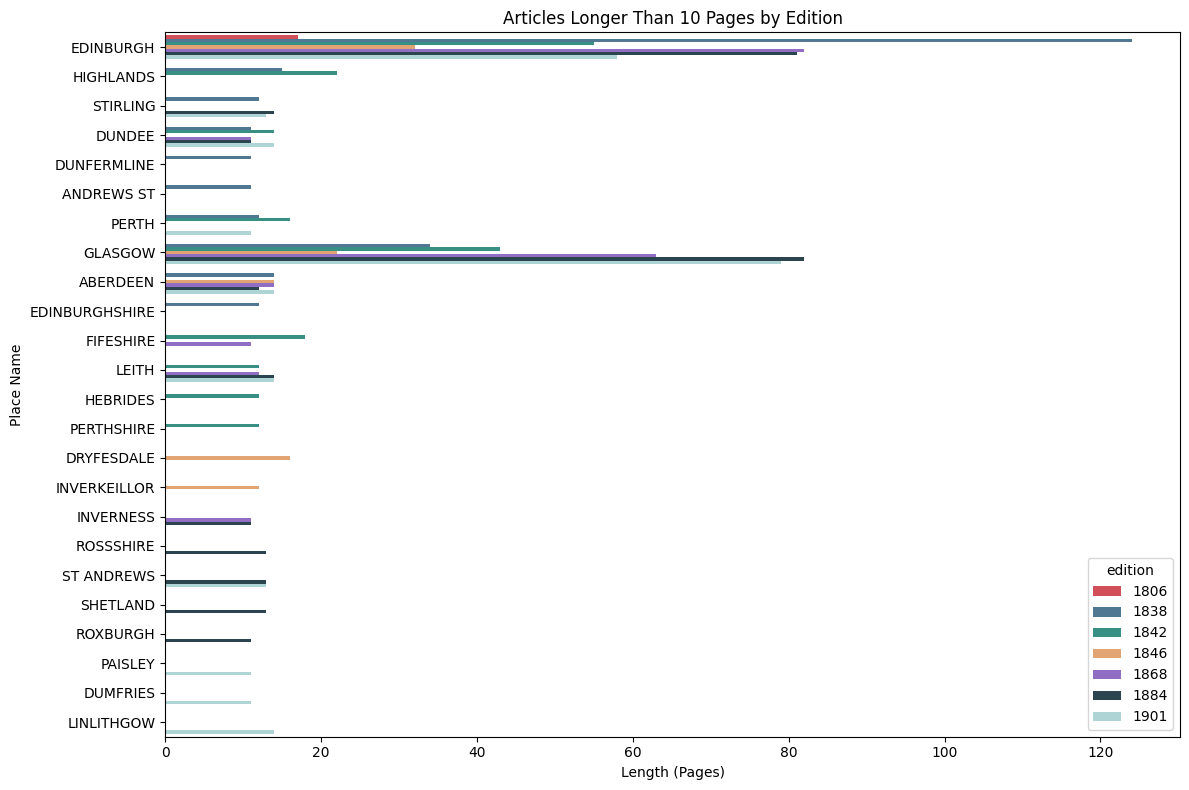

In [ ]:
# Threshold for "long" articles (adjust as needed)
page_threshold = 10

# Collect long articles from all available years
long_articles = []

for year in sorted(gaz_kg_concepts_df["year_published"].unique()):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year].copy()
    df["article_length_pages"] = df["end_page_num"] - df["start_page_num"] + 1
    df_long = df[df["article_length_pages"] > page_threshold]

    for _, row in df_long.iterrows():
        long_articles.append({
            "edition": year,
            "record_name": row["record_name"],
            "length": row["article_length_pages"]
        })

# Convert to DataFrame
long_df = pd.DataFrame(long_articles)

# Custom 10-color palette
custom_palette = sns.color_palette([
    "#E63946",  # red
    "#457B9D",  # blue
    "#2A9D8F",  # teal
    "#F4A261",  # orange
    "#8D5FD3",  # purple
    "#264653",  # dark slate
    "#A8DADC",  # light teal
    "#FFB703",  # golden yellow
    "#D90429",  # crimson
    "#118AB2"   # deep cyan
])

# Plot: long articles by edition
plt.figure(figsize=(12, 8))
sns.barplot(data=long_df, x="length", y="record_name", hue="edition", dodge=True, palette=custom_palette)
plt.title(f"Articles Longer Than {page_threshold} Pages by Edition")
plt.xlabel("Length (Pages)")
plt.ylabel("Place Name")
plt.tight_layout()
plt.show()



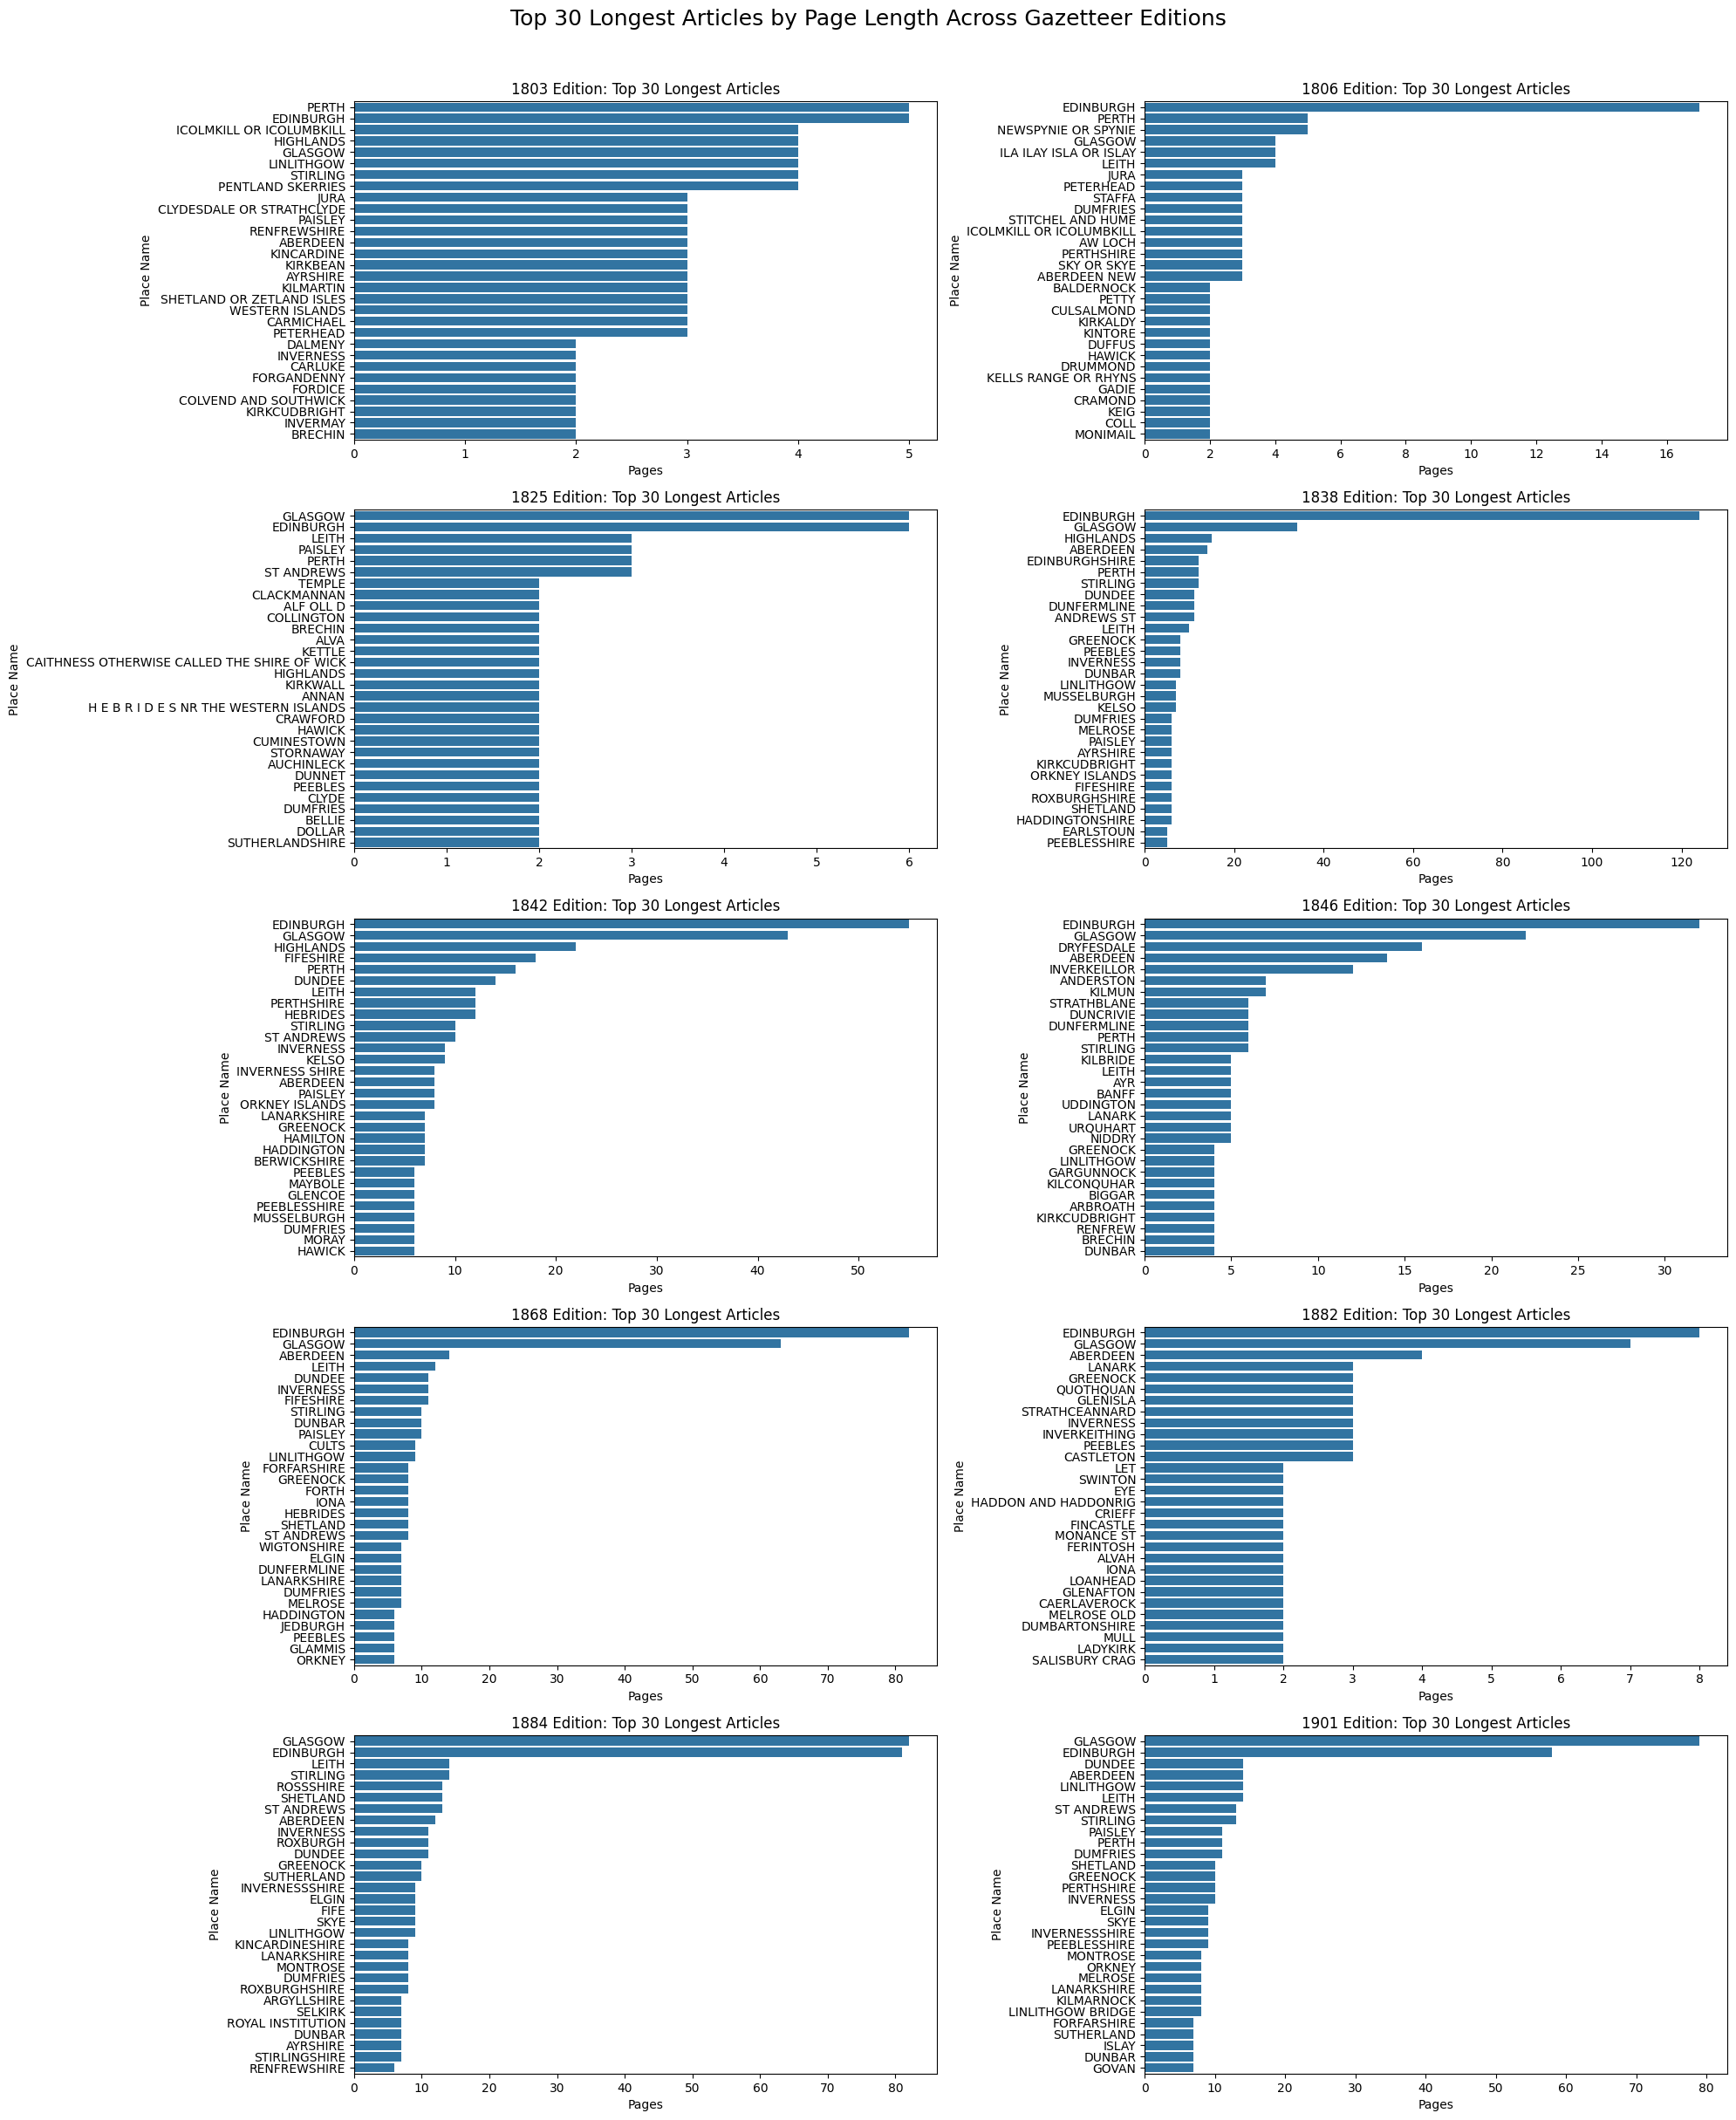

In [ ]:
# Ensure article length column is calculated
gaz_kg_concepts_df = gaz_kg_concepts_df.copy()
gaz_kg_concepts_df["article_length_pages"] = gaz_kg_concepts_df["end_page_num"] - gaz_kg_concepts_df["start_page_num"] + 1

# Get unique sorted years
editions = sorted(gaz_kg_concepts_df["year_published"].unique())

# Create a 6x2 grid of subplots (adjust if needed)
fig, axes = plt.subplots(6, 2, figsize=(20, 30))
axes = axes.flatten()

for i, year in enumerate(editions):
    if i >= len(axes):
        break  # Avoid index errors if more years than subplots

    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year].copy()
    longest = df.sort_values("article_length_pages", ascending=False)[["record_name", "article_length_pages"]].head(30)

    sns.barplot(
        x="article_length_pages",
        y="record_name",
        data=longest,
        ax=axes[i]
    )
    axes[i].set_title(f"{year} Edition: Top 30 Longest Articles")
    axes[i].set_xlabel("Pages")
    axes[i].set_ylabel("Place Name")

# Remove any unused subplot axes
for j in range(len(editions), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Top 30 Longest Articles by Page Length Across Gazetteer Editions", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


## 7. Top N Articles Across All Editions

<ipython-input-47-1958a72c03f3>:27: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(


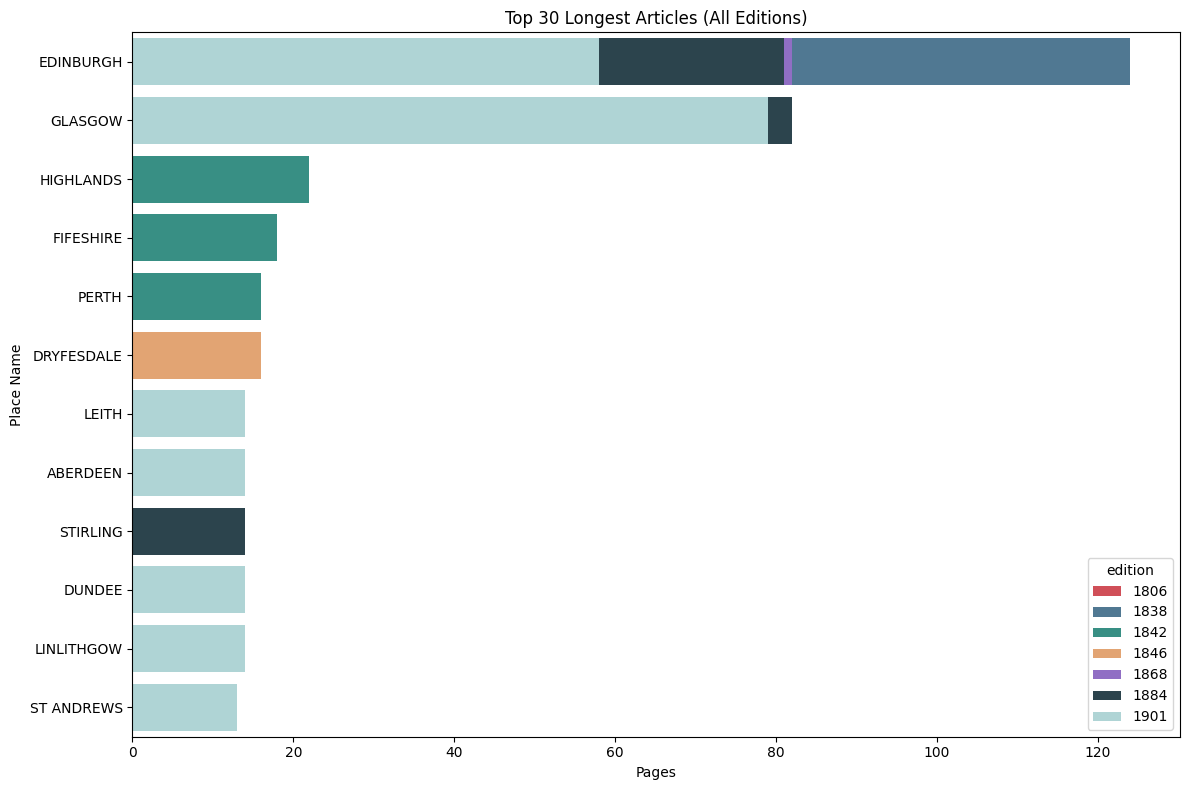

In [ ]:
# Copy and prepare DataFrame
df = gaz_kg_concepts_df.copy()
df["edition"] = df["year_published"]
df["article_length_pages"] = df["end_page_num"] - df["start_page_num"] + 1

# Get top 30 longest articles across all editions
top_30_longest = df.sort_values("article_length_pages", ascending=False)[
    ["record_name", "article_length_pages", "edition"]
].head(30)

# Custom 10-color palette
custom_palette = sns.color_palette([
    "#E63946",  # red
    "#457B9D",  # blue
    "#2A9D8F",  # teal
    "#F4A261",  # orange
    "#8D5FD3",  # purple
    "#264653",  # dark slate
    "#A8DADC",  # light teal
    "#FFB703",  # golden yellow
    "#D90429",  # crimson
    "#118AB2"   # deep cyan
])

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_30_longest,
    x="article_length_pages",
    y="record_name",
    hue="edition",
    dodge=False,
    palette=custom_palette
)
plt.title("Top 30 Longest Articles (All Editions)")
plt.xlabel("Pages")
plt.ylabel("Place Name")
plt.tight_layout()
plt.show()



## 8. Word Count Distribution by Edition

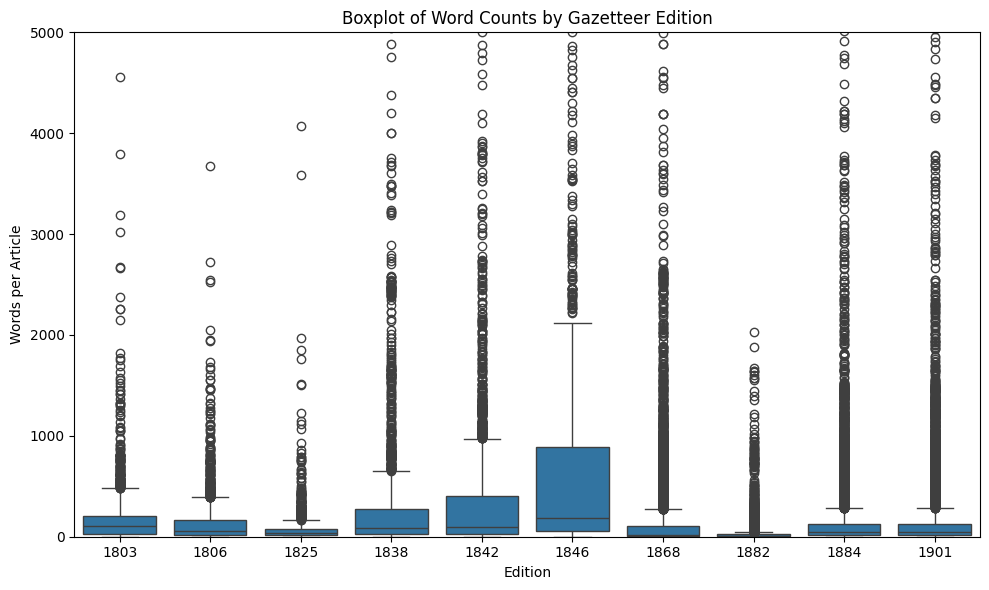

In [ ]:
# Prepare DataFrame
combined = gaz_kg_concepts_df.copy()
combined["edition"] = combined["year_published"]

# Compute word count from description
combined["word_count"] = combined["description"].apply(lambda x: len(str(x).split()))

# Clean invalid word counts
combined = combined[pd.to_numeric(combined["word_count"], errors="coerce").notna()]
combined["word_count"] = combined["word_count"].astype(float)

# Ensure editions are ordered categories
combined["edition"] = pd.Categorical(
    combined["edition"],
    categories=sorted(combined["edition"].unique()),
    ordered=True
)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined, x="edition", y="word_count")
plt.title("Boxplot of Word Counts by Gazetteer Edition")
plt.xlabel("Edition")
plt.ylabel("Words per Article")
plt.ylim(0, 5000)
plt.tight_layout()
plt.show()




## 9. Most Frequent Words

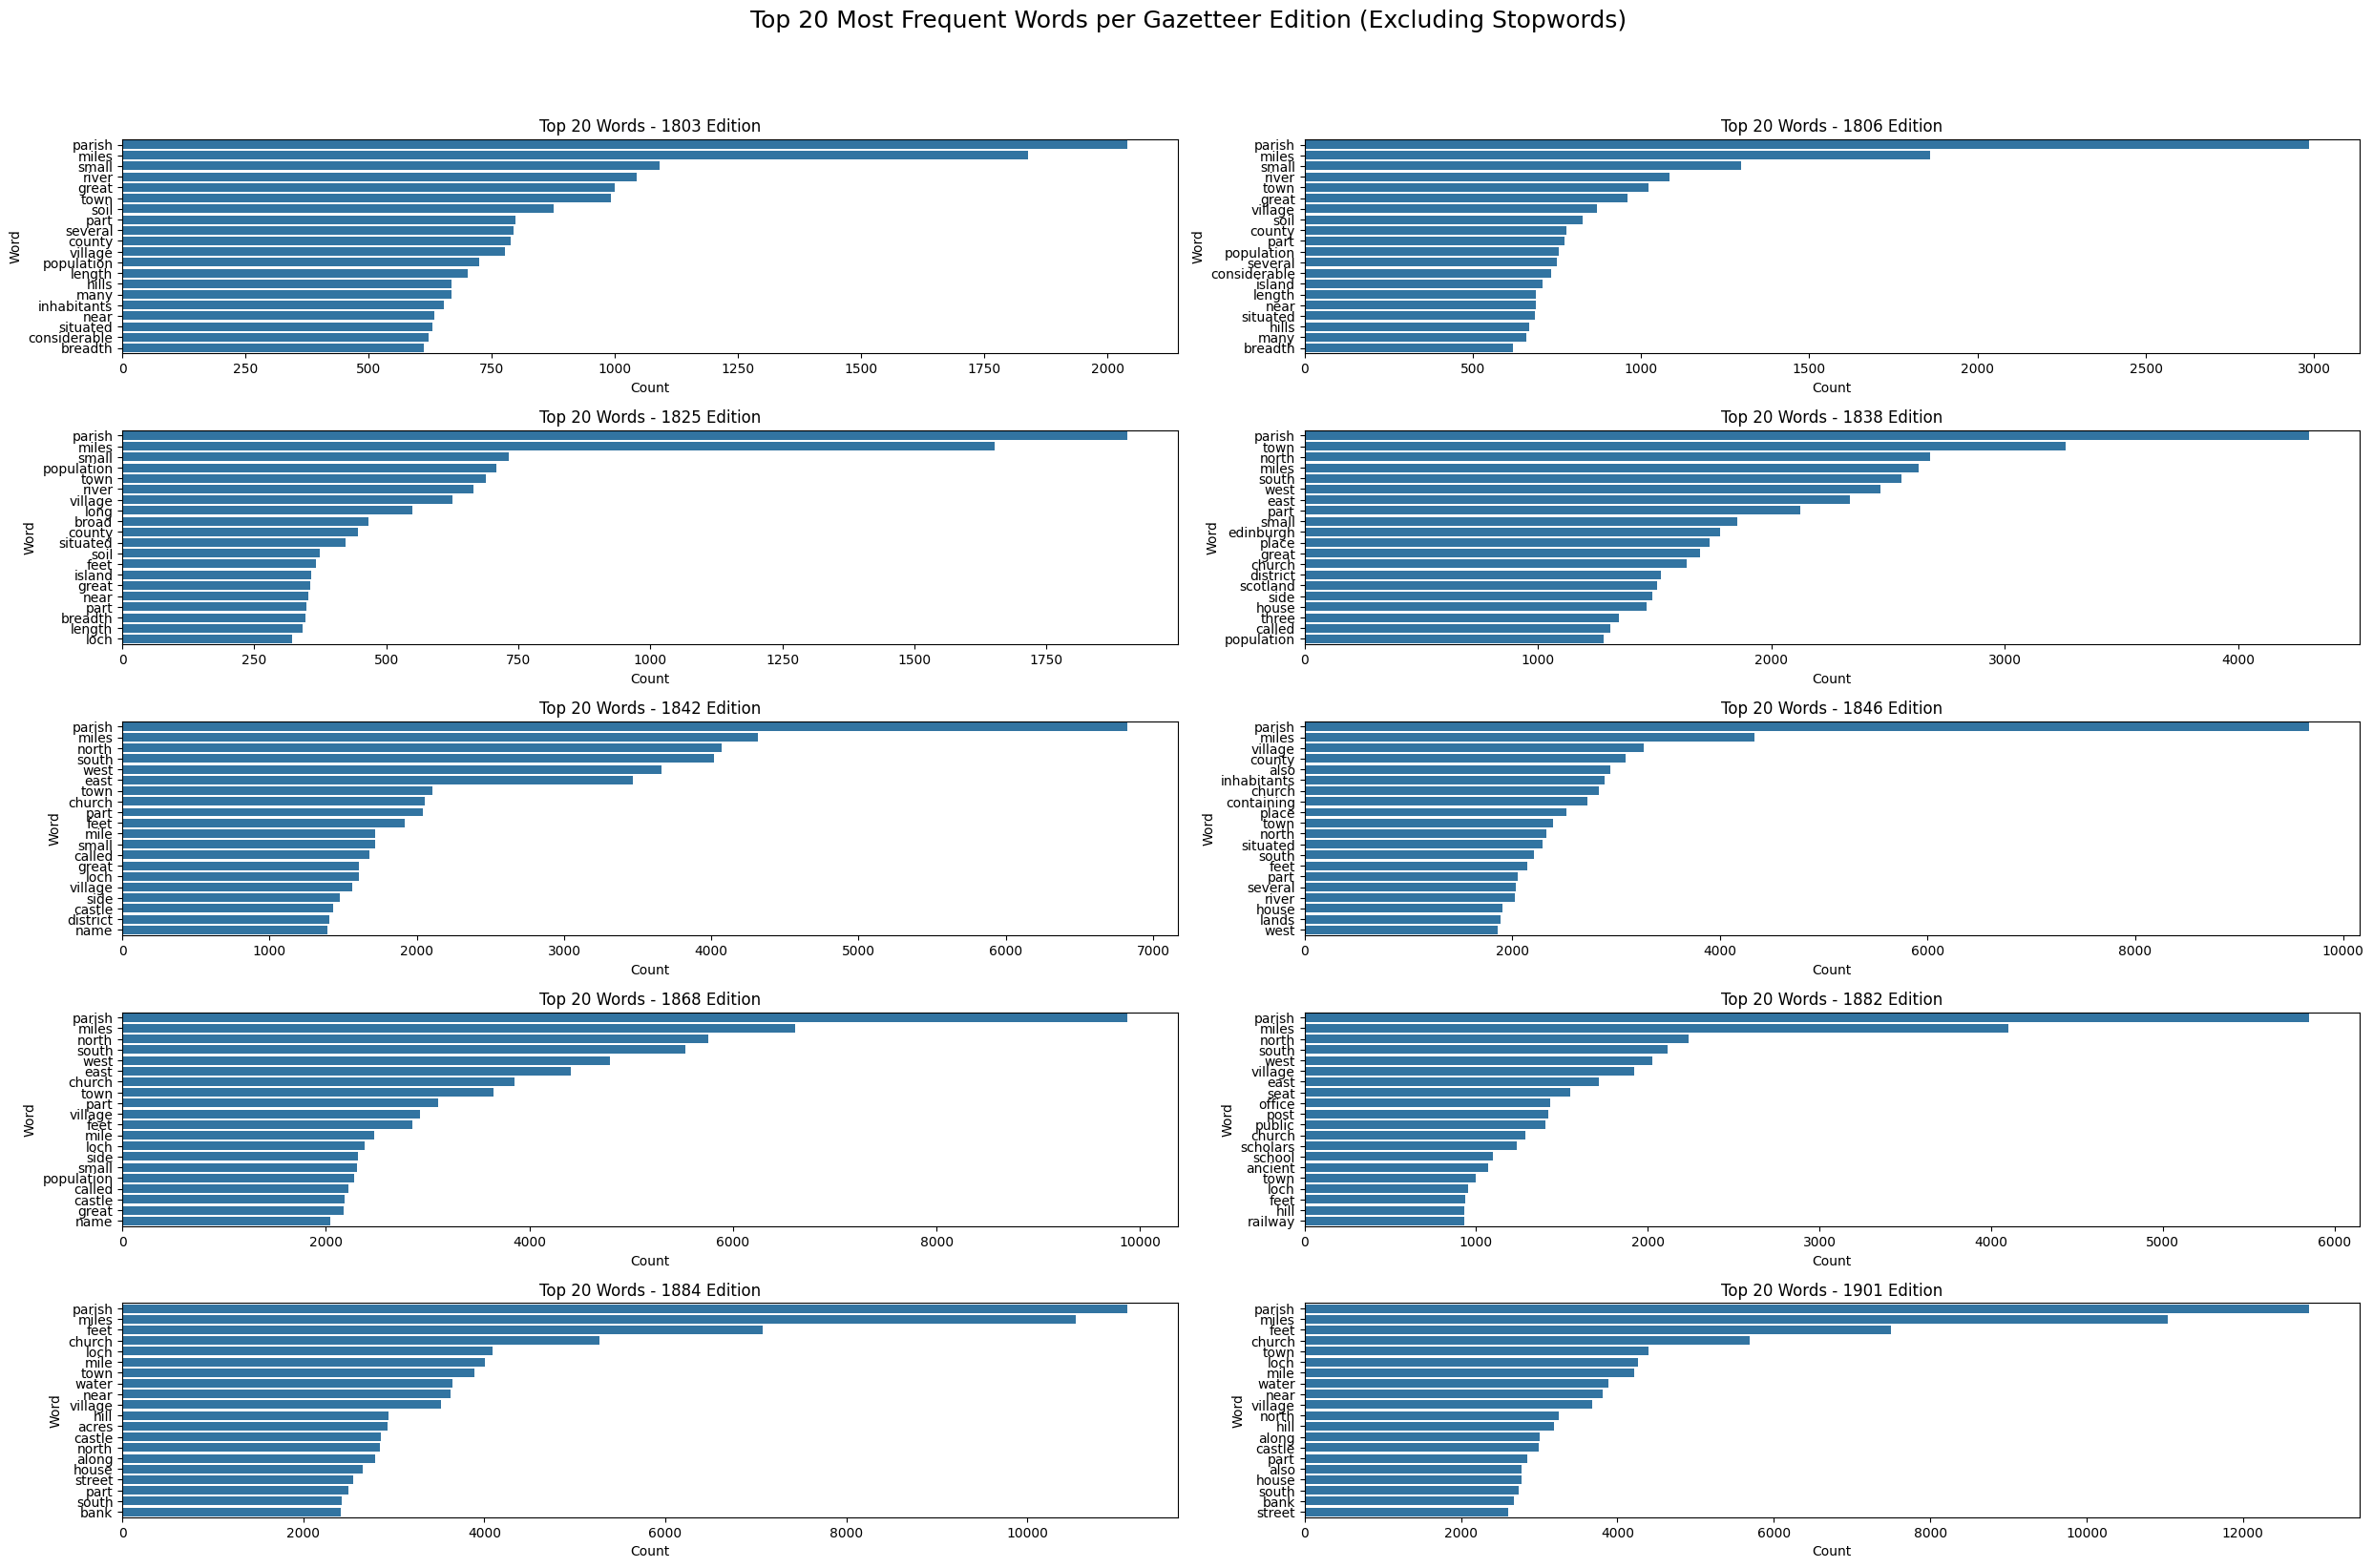

In [ ]:
# Get list of available editions
editions = sorted(gaz_kg_concepts_df["year_published"].unique())

# Set up subplots
fig, axes = plt.subplots(6, 2, figsize=(25, 20))  # 4 rows x 2 columns = 8 slots
axes = axes.flatten()

# Generate plots
for i, year in enumerate(editions):
    if i >= len(axes):
        break  # Safety check if more editions than subplot slots

    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]

    # Join all descriptions into a single string
    all_words = " ".join(df["description"].dropna()).lower()
    words = re.findall(r'\b[a-z]{4,}\b', all_words)  # Keep words with 4+ letters
    filtered_words = [word for word in words if word not in stop_words]
    common_words = Counter(filtered_words).most_common(20)

    # Plot top words
    words_df = pd.DataFrame(common_words, columns=["word", "count"])
    sns.barplot(x="count", y="word", data=words_df, ax=axes[i])
    axes[i].set_title(f"Top 20 Words - {year} Edition")
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel("Word")

# Remove unused subplots if any
for j in range(len(editions), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Top 20 Most Frequent Words per Gazetteer Edition (Excluding Stopwords)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




## 10. Article Count by First letter

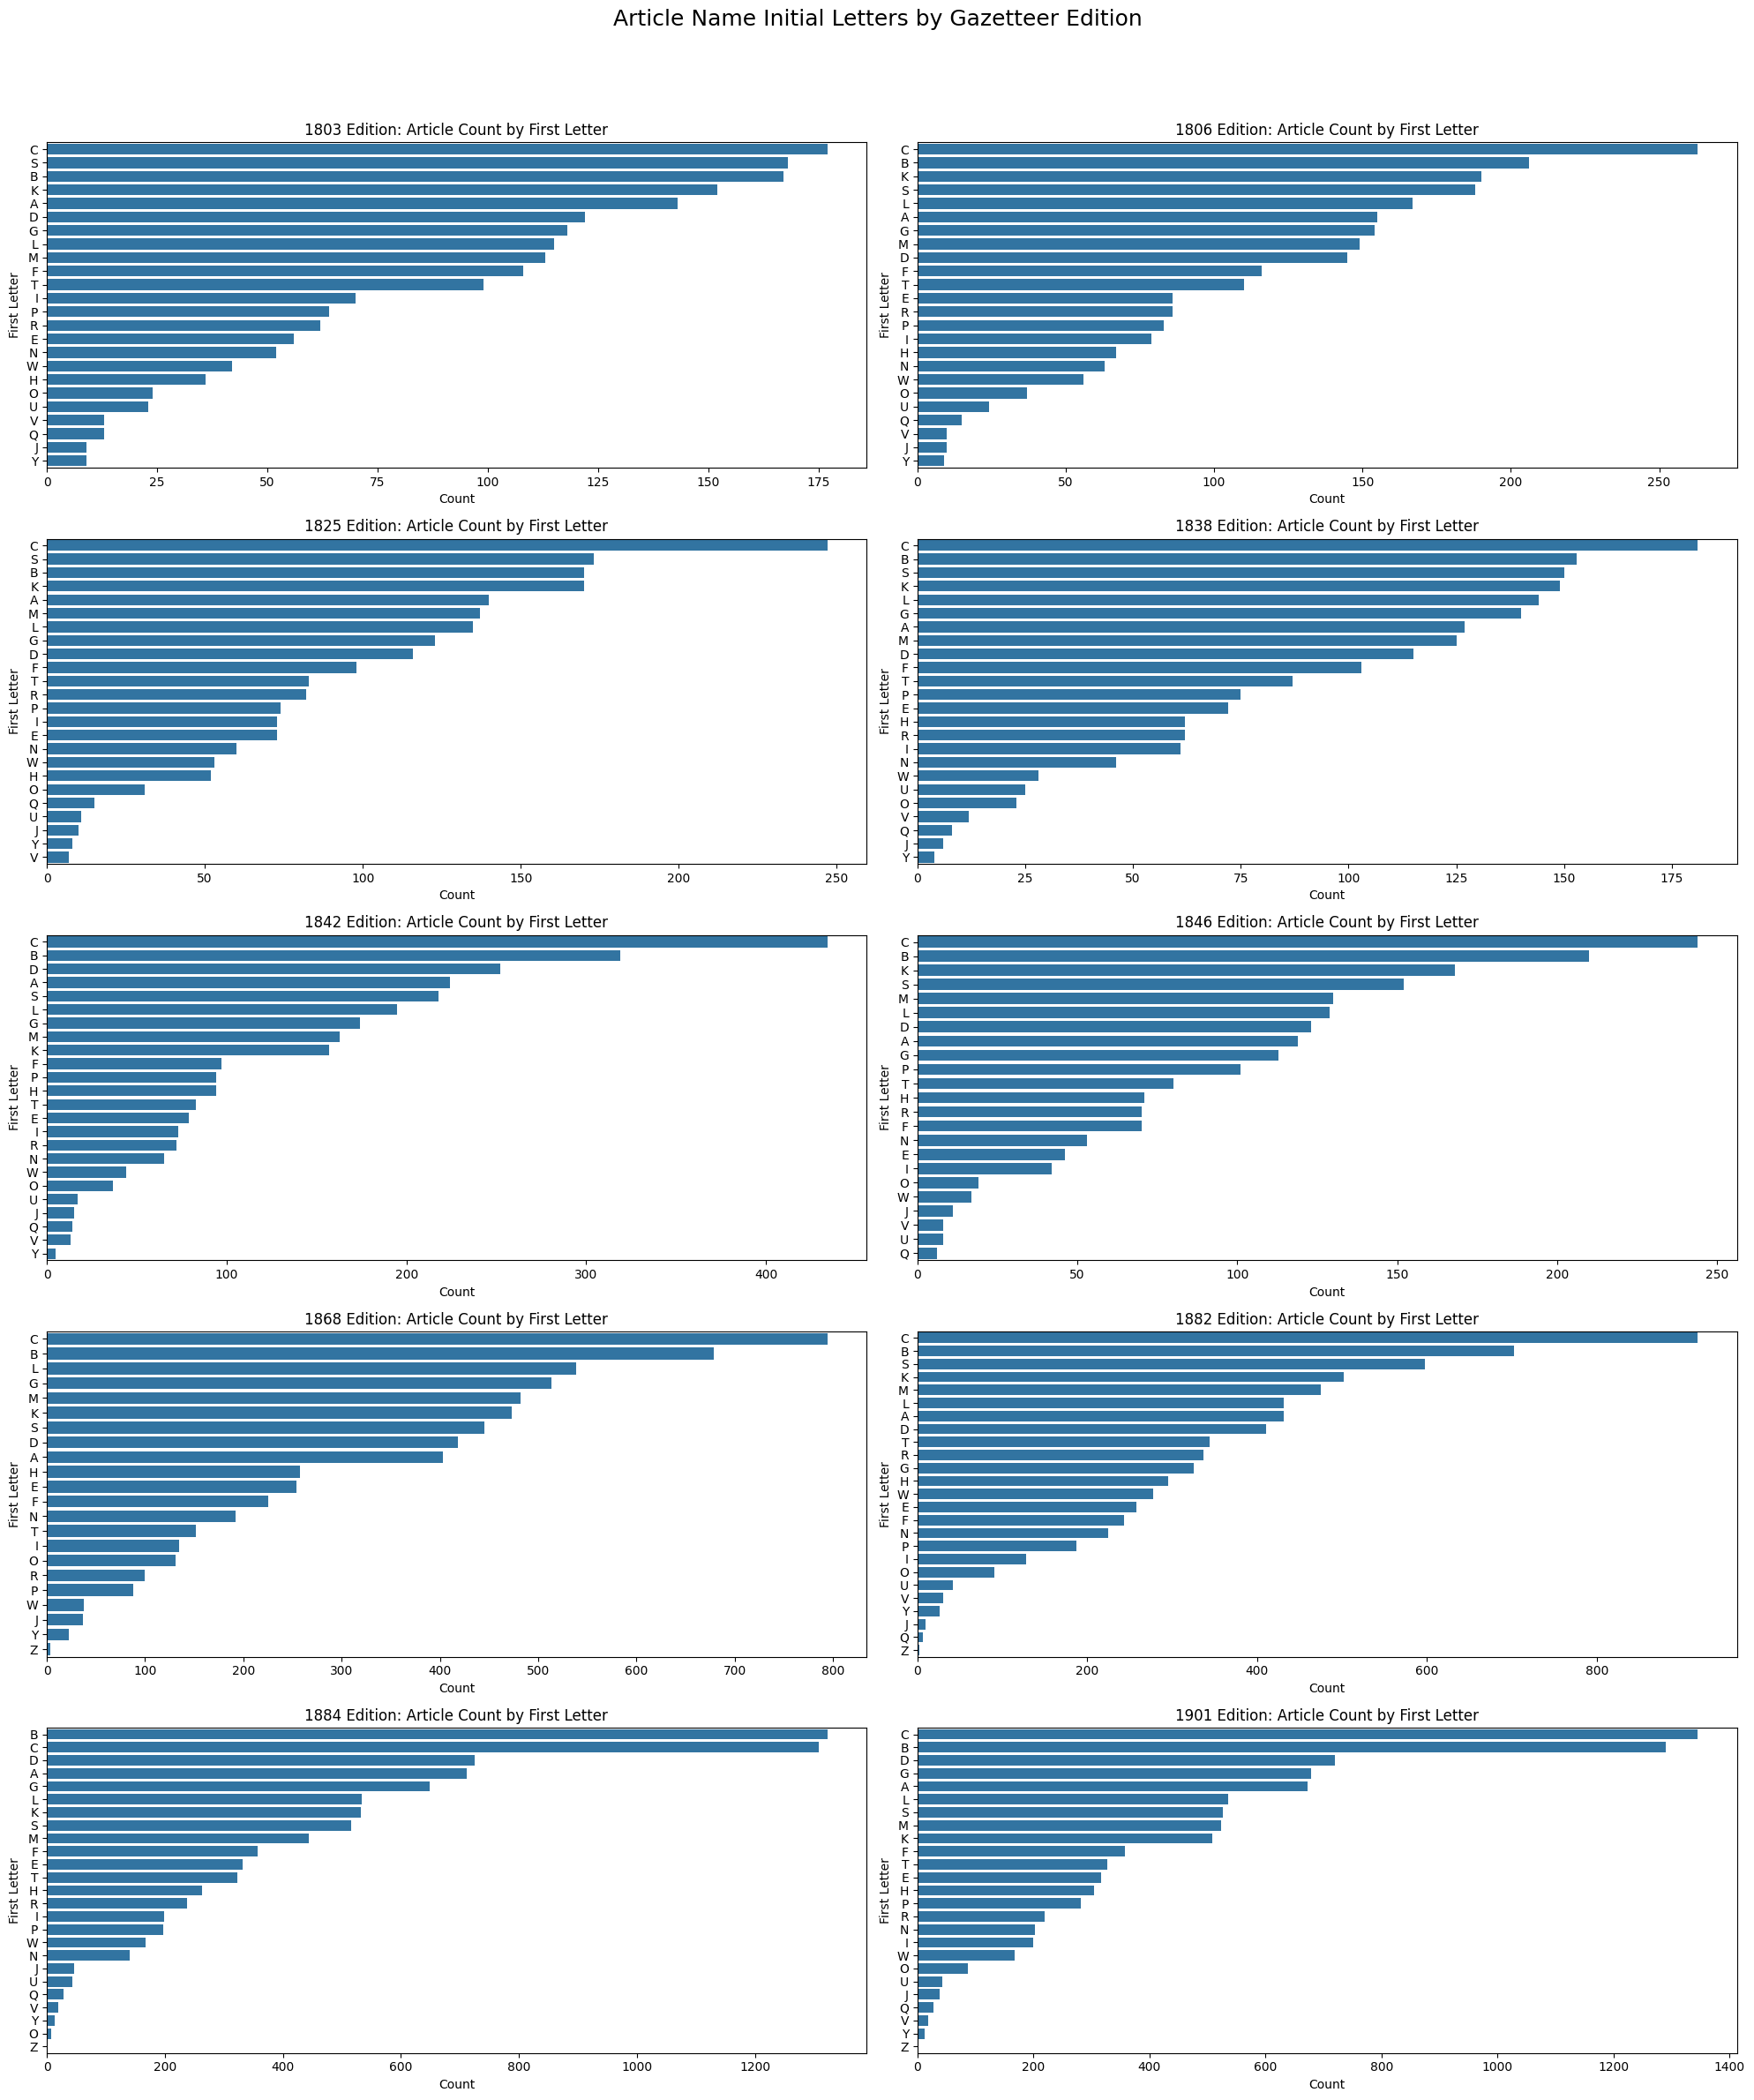

In [ ]:
# Get sorted unique editions
editions = sorted(gaz_kg_concepts_df["year_published"].unique())

# Set up subplot grid (adjust rows/cols to fit all editions)
n = len(editions)
ncols = 2
nrows = (n + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 5))
axes = axes.flatten()

# Generate plots per edition
for i, year in enumerate(editions):
    if i >= len(axes):
        break

    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year].copy()
    df["first_letter"] = df["record_name"].astype(str).str[0]  # Avoid NaNs or non-string values
    order = df["first_letter"].value_counts().index

    sns.countplot(y="first_letter", data=df, order=order, ax=axes[i])
    axes[i].set_title(f"{year} Edition: Article Count by First Letter")
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel("First Letter")

# Remove any unused subplot axes
for j in range(len(editions), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Article Name Initial Letters by Gazetteer Edition", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



## 11. Adjective Extraction Across Editions (Side-by-Side Comparison)

In [ ]:

nlp.max_length = 2_000_000  # Increase max length if needed

# Get all available editions
editions = sorted(gaz_kg_concepts_df["year_published"].unique())

# Create a subplot grid (adjust rows/cols based on number of editions)
n = len(editions)
ncols = 2
nrows = (n + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 5))
axes = axes.flatten()

# Loop through each edition
for i, year in enumerate(editions):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]
    text_sample = " ".join(df["description"].dropna().astype(str)[:500])  # Limit to 500 articles
    doc = nlp(text_sample)

    adjectives = [token.lemma_ for token in doc if token.pos_ == "ADJ" and len(token.text) > 3]
    top_adjs = Counter(adjectives).most_common(15)

    adj_df = pd.DataFrame(top_adjs, columns=["adjective", "count"])

    if i < len(axes):
        adj_df.plot.barh(x="adjective", y="count", ax=axes[i], legend=False)
        axes[i].set_title(f"{year} Edition – Top Adjectives")
        axes[i].invert_yaxis()
    else:
        print(f"Skipping plot for year {year} due to insufficient subplots.")

plt.suptitle("Most Common Adjectives Describing Places in Gazetteers", fontsize=18)
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




## 12. Top 20 Referenced Places (in the text) per Edition

This does not mean that we are looking in the `reference_terms` column - this is done later in this notebook. Here we are looking the `text` column and looking for references of places

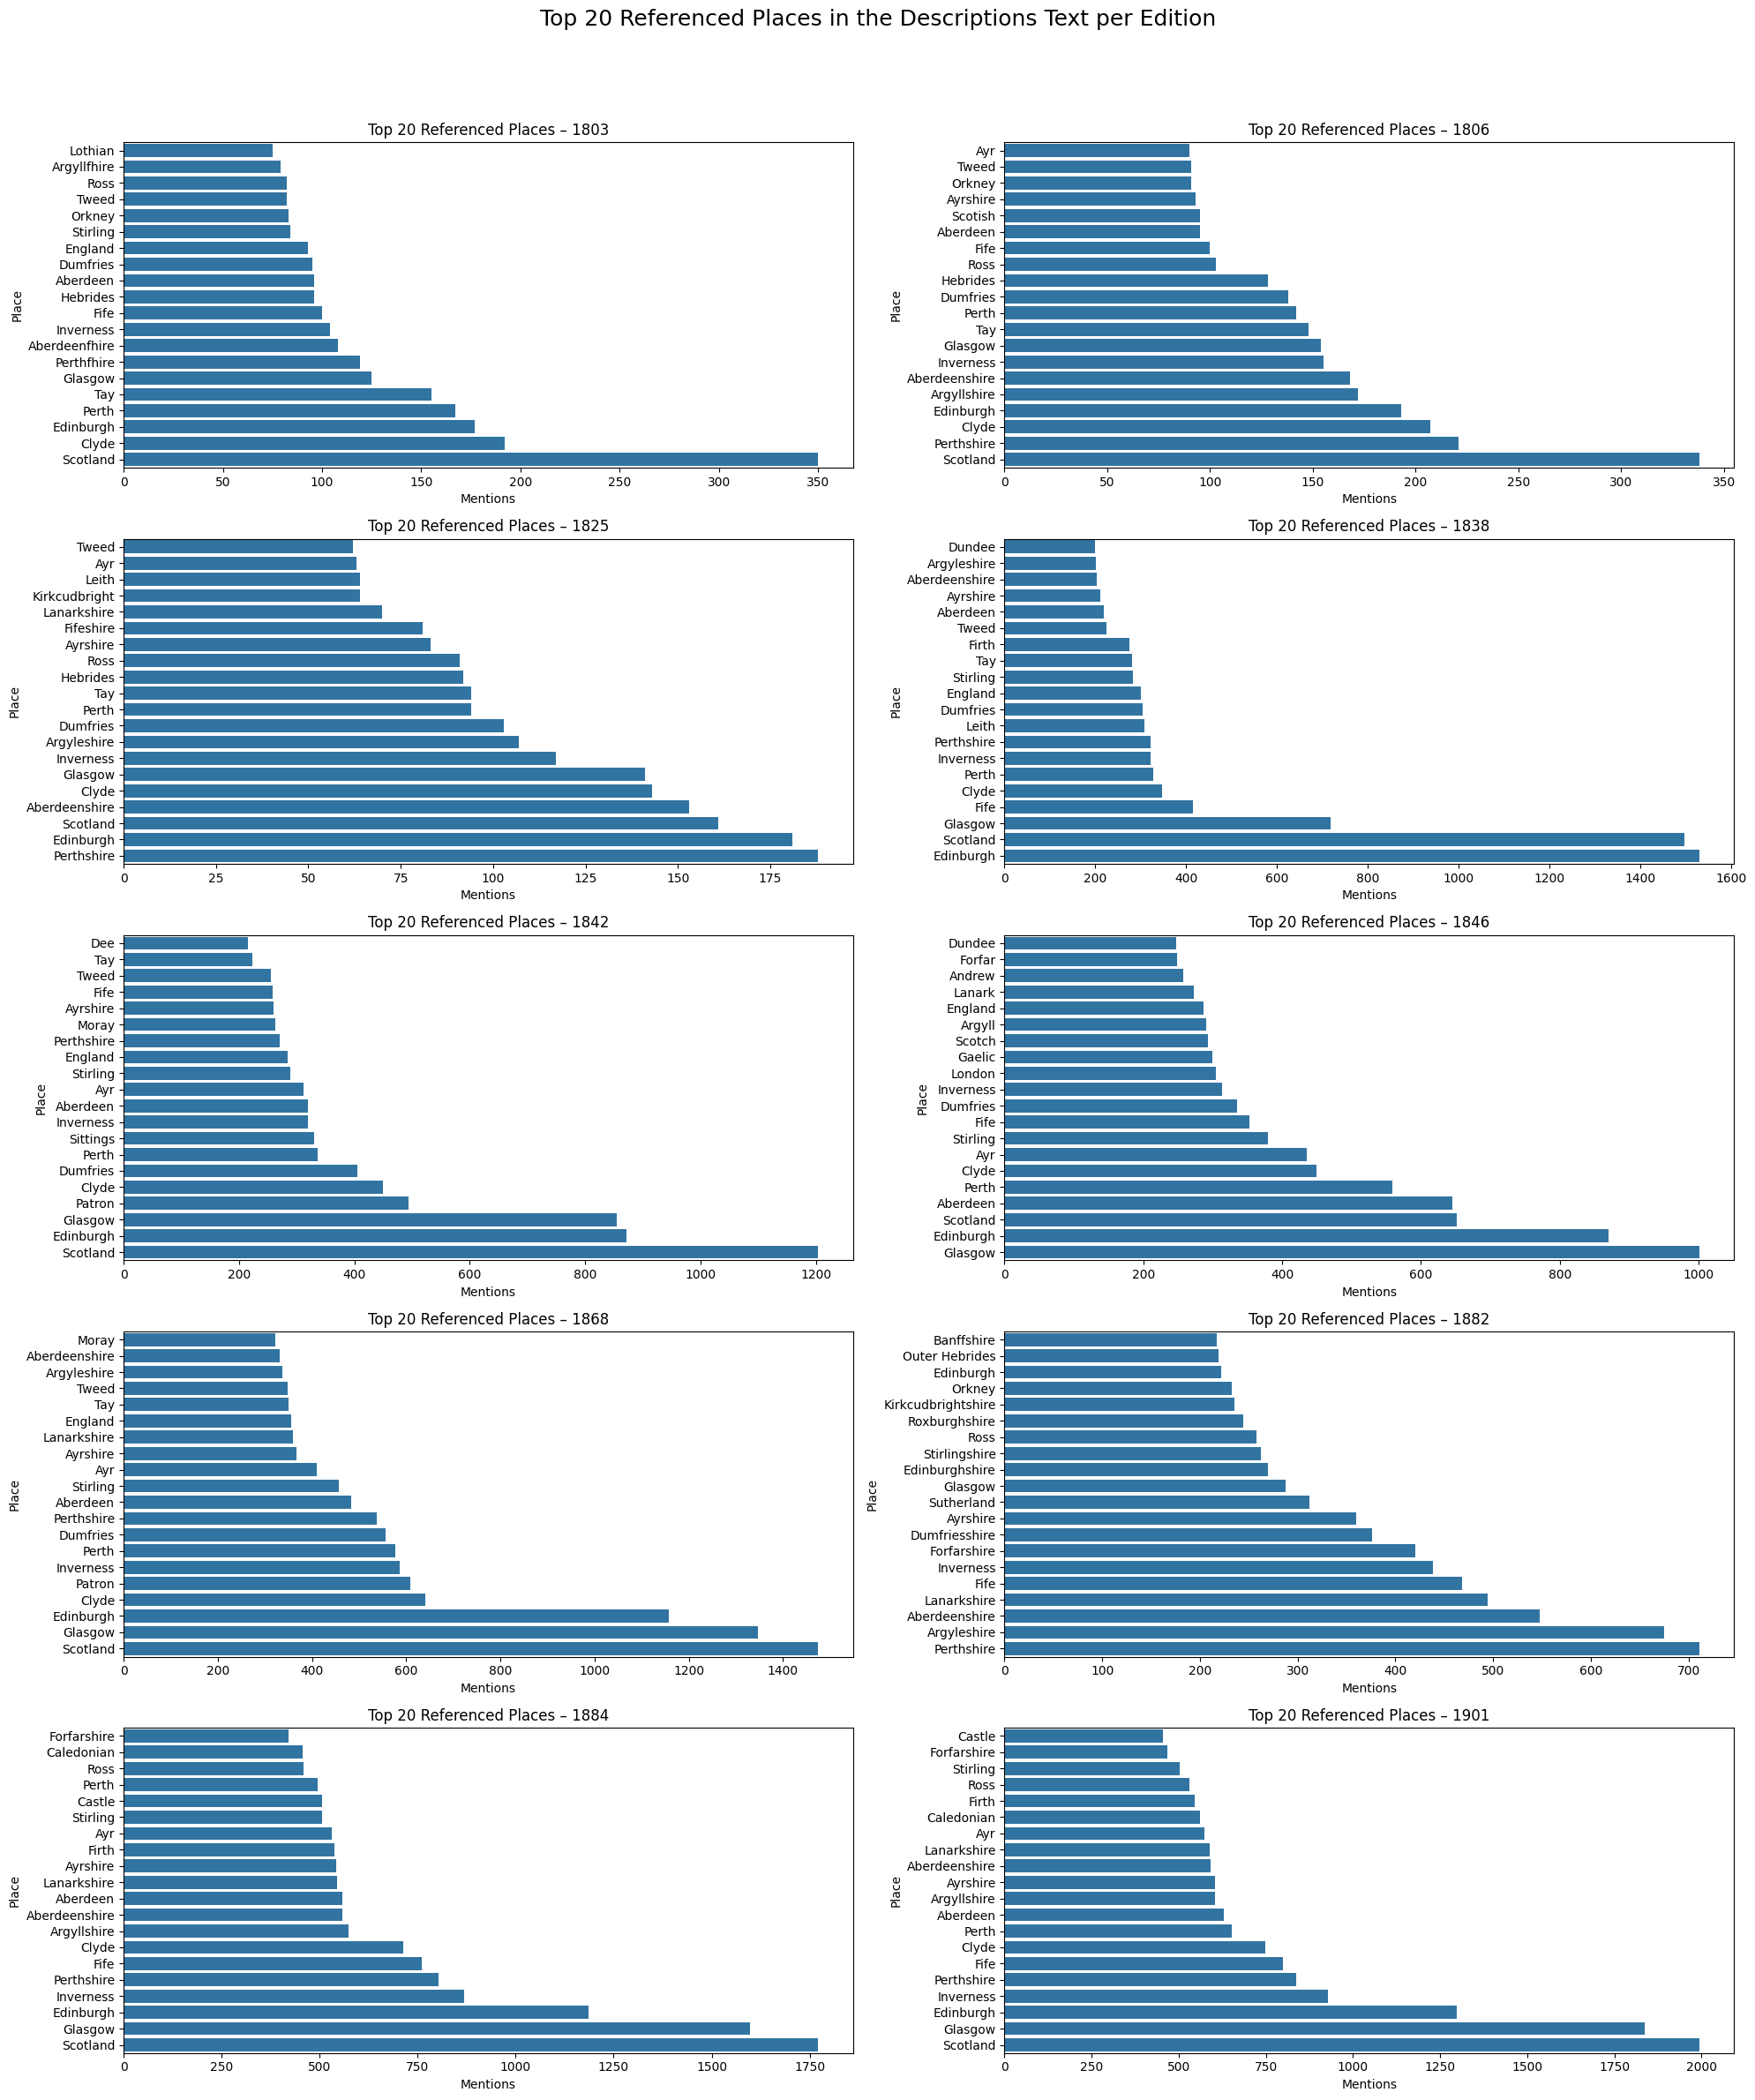

In [ ]:
# Already imported: stopwords, nltk, etc.

# Add lowercase English stopwords
lower_stopwords = set(stopwords.words('english'))

title_terms = {
    "Mr", "Mrs", "Miss", "Ms", "Earl", "Lord", "Lady", "Sir", "Duke", "Baron",
    "Count", "Rev", "St", "Saint", "King", "Queen", "Dr", "Captain", "Major", "United Presbyterian", "United Presbyterian", "United", "Presbyterian",
    "General", "Colonel", "Dean", "Professor", "Archbishop", "Crown", "English", "Pop", "Free", "Real", "Established"
}

custom_exclude = {
    "Volume", "Gazetteer", "Map", "County", "Parish", "Description", "Assessed", "Loch", "Houses",
    "Edition", "Near", "Population", "Besides", "Esq", "Scots", "Roman", "Unappropriated",
    "Stipend", "Schoolmaster", "Tuesday", "Free", "English", "Frith", "Forth", "James",
    "Reformation", "David", "Scottish", "Charles", "Sur", "Valuation", "Ord"
}

# Get all editions
editions = sorted(gaz_kg_concepts_df["year_published"].unique())

# Set up subplots
n = len(editions)
ncols = 2
nrows = (n + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 5))
axes = axes.flatten()

# Analyze each edition
for i, year in enumerate(editions):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]
    full_text = " ".join(df["description"].dropna().astype(str))

    # Extract capitalized multi-word sequences
    place_candidates = re.findall(r'\b[A-Z][a-z]+(?:\s[A-Z][a-z]+)*\b', full_text)

    # Filter out stopwords, title terms, and custom exclusions
    filtered_places = [
        phrase for phrase in place_candidates
        if all(
            word not in stop_words and                 # e.g., 'The', 'At'
            word.lower() not in lower_stopwords and    # e.g., 'the', 'at'
            word not in title_terms and
            word not in custom_exclude
            for word in phrase.split()
        )
    ]

    top_places = Counter(filtered_places).most_common(20)
    place_df = pd.DataFrame(top_places, columns=["Place", "Mentions"])

    if i < len(axes):
        sns.barplot(data=place_df, x="Mentions", y="Place", ax=axes[i])
        axes[i].set_title(f"Top 20 Referenced Places – {year}")
        axes[i].invert_yaxis()
    else:
        print(f"Skipping year {year} (not enough subplots)")

# Remove unused subplots
for j in range(len(editions), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Top 20 Referenced Places in the Descriptions Text per Edition", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




## 13. Summary Table of Repeat Counts

In [ ]:
# Create a mapping from place name to editions in which it is repeated
repeated_by_edition = defaultdict(set)

# Loop over each edition
for year in sorted(gaz_kg_concepts_df["year_published"].unique()):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]
    name_counts = df["record_name"].value_counts()
    repeated_names = set(name_counts[name_counts > 1].index)
    for name in repeated_names:
        repeated_by_edition[name].add(year)

# Create summary DataFrame
summary = [(name, sorted(list(years)), len(years)) for name, years in repeated_by_edition.items()]
summary_df = pd.DataFrame(summary, columns=["record_name", "editions", "num_editions"])
summary_df = summary_df.sort_values("num_editions", ascending=False)

# Show top results
print(summary_df.head(10))




    record_name                                           editions  \
24       NEWTON  [1803, 1806, 1825, 1838, 1842, 1846, 1868, 188...   
93     ABERDOUR   [1806, 1825, 1838, 1842, 1846, 1868, 1884, 1901]   
46    THORNHILL         [1803, 1806, 1838, 1846, 1882, 1884, 1901]   
69     LADYKIRK         [1806, 1825, 1842, 1846, 1882, 1884, 1901]   
182    KIRKHILL         [1838, 1842, 1846, 1868, 1882, 1884, 1901]   
105  KINCARDINE         [1806, 1838, 1846, 1868, 1882, 1884, 1901]   
141    NEWBURGH         [1838, 1842, 1846, 1868, 1882, 1884, 1901]   
48       LESLIE         [1803, 1825, 1846, 1868, 1882, 1884, 1901]   
35    SYMINGTON         [1803, 1806, 1825, 1838, 1868, 1882, 1884]   
20        LOGIE               [1803, 1846, 1868, 1882, 1884, 1901]   

     num_editions  
24              9  
93              8  
46              7  
69              7  
182             7  
105             7  
141             7  
48              7  
35              7  
20              6  


In [ ]:
for year in sorted(gaz_kg_concepts_df["year_published"].unique()):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]
    repeats = df["record_name"].value_counts()
    num_repeats = (repeats > 1).sum()
    print(f"{year}: {num_repeats} repeated names")



1803: 57 repeated names
1806: 63 repeated names
1825: 51 repeated names
1838: 75 repeated names
1842: 83 repeated names
1846: 77 repeated names
1868: 241 repeated names
1882: 428 repeated names
1884: 523 repeated names
1901: 571 repeated names


## 14. ALTER NAMES

In [ ]:
# Get all unique editions
editions = sorted(gaz_kg_concepts_df["year_published"].unique())

# Initialize list to store results
alter_names_stats = []

# Loop through each edition and filtered dataframe
for edition in editions:
    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == edition].copy()

    # Ensure alter_names is parsed as a list
    df['alter_names'] = df['alter_names'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Calculate statistics
    total_articles = len(df)
    articles_with_alter_names = df['alter_names'].apply(lambda x: isinstance(x, list) and len(x) > 0).sum()
    total_alter_names = df['alter_names'].apply(lambda x: len(x) if isinstance(x, list) else 0).sum()
    percent_with_alter_names = round((articles_with_alter_names / total_articles) * 100, 2) if total_articles > 0 else 0.0

    alter_names_stats.append({
        'edition': edition,
        'total_articles': total_articles,
        'articles_with_alter_names': articles_with_alter_names,
        'total_alter_names': total_alter_names,
        'percent_with_alter_names': percent_with_alter_names
    })

# Create and display summary DataFrame
alter_names_summary_df = pd.DataFrame(alter_names_stats)
display(alter_names_summary_df)



,edition,total_articles,articles_with_alter_names,total_alter_names,percent_with_alter_names
0,1803,1955,231,231,11.82
1,1806,2468,281,281,11.39
2,1825,2141,128,128,5.98
3,1838,1958,114,114,5.82
4,1842,2938,114,114,3.88
5,1846,1990,1,1,0.05
6,1868,6382,76,76,1.19
7,1882,7297,70,70,0.96
8,1884,9115,359,359,3.94
9,1901,9407,397,397,4.22


## 15. Referenced Terms (See ....)

In [ ]:
# Get all unique editions
editions = sorted(gaz_kg_concepts_df["year_published"].unique())

# Initialize list to store results
reference_stats = []

for edition in editions:
    df = gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == edition].copy()

    # Safely evaluate 'references' if stored as string
    df['references'] = df['references'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    total_articles = len(df)
    articles_with_references = df['references'].apply(lambda x: isinstance(x, list) and len(x) > 0).sum()
    total_references = df['references'].apply(lambda x: len(x) if isinstance(x, list) else 0).sum()
    percent_with_references = round((articles_with_references / total_articles) * 100, 2) if total_articles > 0 else 0.0

    reference_stats.append({
        'edition': edition,
        'total_articles': total_articles,
        'articles_with_references': articles_with_references,
        'total_references': total_references,
        'percent_with_references': percent_with_references
    })

# Create and display summary DataFrame
reference_summary_df = pd.DataFrame(reference_stats)
display(reference_summary_df)





,edition,total_articles,articles_with_references,total_references,percent_with_references
0,1803,1955,67,72,3.43
1,1806,2468,52,54,2.11
2,1825,2141,24,26,1.12
3,1838,1958,52,54,2.66
4,1842,2938,330,331,11.23
5,1846,1990,80,81,4.02
6,1868,6382,1123,1151,17.60
7,1882,7297,168,170,2.30
8,1884,9115,930,961,10.20
9,1901,9407,986,1019,10.48


## 16. Track mentions of keywords over time & TF-IDF Term Trends



### 16.1 Trace mentions of "railway", "harbour", or "cotton

In [ ]:
keywords = ["railway", "harbour", "cotton"]

for kw in keywords:
    print(f"\n📈 Mentions of '{kw}':")
    for year, df in dfs.items():
        count = df["description"].dropna().str.contains(kw, case=False).sum()
        print(f"{year}: {count}")




📈 Mentions of 'railway':
1803: 0
1806: 0
1825: 0
1838: 11
1842: 82
1846: 99
1868: 603
1882: 668
1884: 949
1901: 1231

📈 Mentions of 'harbour':
1803: 229
1806: 250
1825: 162
1838: 185
1842: 214
1846: 289
1868: 301
1882: 179
1884: 306
1901: 340

📈 Mentions of 'cotton':
1803: 57
1806: 59
1825: 28
1838: 72
1842: 80
1846: 136
1868: 95
1882: 15
1884: 87
1901: 83


📊 Obsvervation

The trends reflect broader economic and technological shifts in Scotland during the 19th century.

| Term     | Trend Summary |
|----------|----------------|
| **Railway** 🚂 | **Absent** in early editions (1803–1825). First appears in 1838, then surges in 1842 and steadily rises thereafter, peaking in 1901. This mirrors the rapid expansion of rail infrastructure during the Industrial Revolution. |
| **Harbour** ⚓ | Consistently **high presence** across all editions, indicating enduring emphasis on maritime trade and coastal infrastructure. Minor fluctuations, but generally stable from 1803 through 1901. |
| **Cotton** 🧵 | Shows **fluctuating prominence**: moderate in early editions, drops in 1825, then climbs again in the 1840s with a peak in 1846. Declines toward the late century, possibly due to shifts in industrial centers or sector diversification. |


### 16.2 TF-IDF keyword extraction

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def tfidf_keywords(dfs, top_n=10):
    # Join all descriptions into a single string per edition
    all_texts = [' '.join(df['description'].dropna().astype(str).tolist()) for df in dfs.values()]

    # TF-IDF model
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    terms = vectorizer.get_feature_names_out()

    # Print top terms by TF-IDF score per edition
    for idx, (year, _) in enumerate(dfs.items()):
        scores = tfidf_matrix[idx].toarray().flatten()
        top_indices = scores.argsort()[::-1][:top_n]
        print(f"\n🔹 Top {top_n} TF-IDF terms for {year}:")
        for i in top_indices:
            print(f"{terms[i]} ({scores[i]:.3f})")

# Build the edition-wise DataFrames dynamically
dfs = {
    str(year): gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]
    for year in sorted(gaz_kg_concepts_df["year_published"].unique())
}

# Run TF-IDF keyword extraction
tfidf_keywords(dfs, top_n=10)




🔹 Top 10 TF-IDF terms for 1803:
parish (0.341)
miles (0.307)
small (0.182)
river (0.175)
pariih (0.170)
great (0.167)
town (0.166)
soil (0.146)
county (0.132)
village (0.130)

🔹 Top 10 TF-IDF terms for 1806:
parish (0.466)
miles (0.290)
small (0.203)
river (0.169)
town (0.159)
great (0.150)
village (0.136)
soil (0.129)
county (0.122)
population (0.118)

🔹 Top 10 TF-IDF terms for 1825:
parish (0.488)
miles (0.424)
small (0.188)
population (0.182)
town (0.177)
river (0.171)
village (0.161)
long (0.141)
broad (0.120)
county (0.115)

🔹 Top 10 TF-IDF terms for 1838:
parish (0.316)
town (0.239)
north (0.197)
miles (0.193)
south (0.188)
west (0.181)
east (0.172)
small (0.136)
edinburgh (0.131)
place (0.128)

🔹 Top 10 TF-IDF terms for 1842:
parish (0.399)
miles (0.252)
north (0.238)
south (0.235)
west (0.214)
east (0.202)
town (0.123)
church (0.120)
feet (0.112)
mile (0.100)

🔹 Top 10 TF-IDF terms for 1846:
parish (0.471)
miles (0.211)
village (0.159)
county (0.151)
inhabitants (0.141)
church


 📌 Observations: TF-IDF Term Trends Across Gazetteer Editions (1803–1901)

The TF-IDF results highlight the most distinctive terms per edition, reflecting both stable descriptive structures and evolving geographical focus over time. Below are key observations derived from the top 10 TF-IDF terms for each year:

#### 🏷️ Stable Core Vocabulary
- The word **"parish"** is the **most consistently dominant term** across all editions, underscoring the central role of parishes in the administrative and geographical structure of Scotland.
- Terms like **"miles"**, **"town"**, **"village"**, and **"river"** also appear frequently, indicating a strong focus on physical geography and settlement size.

#### 🧭 Rise of Cardinal Directions
- Starting in **1838**, terms such as **"north"**, **"south"**, **"east"**, and **"west"** begin to appear frequently. This likely reflects a shift toward more spatially explicit descriptions, possibly influenced by better cartographic practices or growing use of directional navigation.

#### 🏛️ Ecclesiastical and Demographic Focus
- Words like **"church"**, **"population"**, and **"inhabitants"** appear with moderate frequency across editions, reflecting the importance of ecclesiastical institutions and demographic metrics in these texts.

#### 📏 Topographic and Measurement Terms
- In later editions (1882–1901), terms like **"feet"**, **"mile"**, and **"seat"** become more prominent—indicating a rise in detailed topographic descriptions and spatial quantification.
- The presence of **"1891"** in 1901 suggests direct reference to census data or contemporary historical anchors.

#### 🌊 Landscape and Natural Features
- **"Loch"**, **"water"**, and **"nw/sw"** appear in 1884–1901, suggesting more frequent and detailed descriptions of bodies of water and compass-point features, possibly reflecting greater surveying accuracy and geographic coverage in later editions.

---

These TF-IDF patterns demonstrate how the language of Scottish place descriptions evolved over the 19th century, moving from general narrative forms toward increasingly spatial, quantified, and standardized vocabulary aligned with statistical geography and modern map-making.


### 16.3 TF-IDF keyword visualization over time

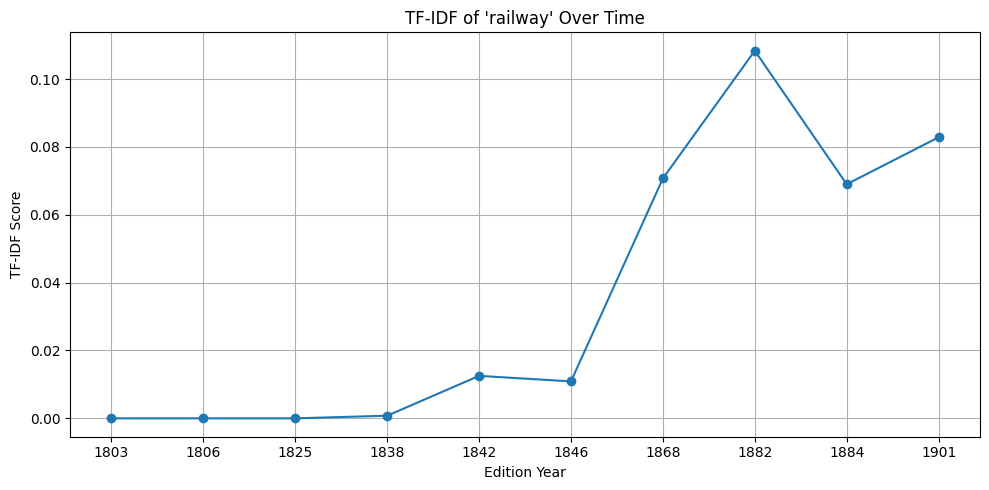

In [7]:
def track_word_tfidf(word, dfs):
    # Prepare text data from cleaned descriptions
    texts = [' '.join(df['description'].dropna().astype(str).tolist()) for df in dfs.values()]

    # Fit TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    terms = vectorizer.get_feature_names_out()

    # Check if the word exists in the vocabulary
    if word.lower() not in terms:
        print(f"'{word}' not found in TF-IDF vocabulary.")
        return

    # Get index and extract TF-IDF values
    word_index = list(terms).index(word.lower())
    tfidf_values = tfidf_matrix[:, word_index].toarray().flatten()

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(list(dfs.keys()), tfidf_values, marker="o")
    plt.title(f"TF-IDF of '{word}' Over Time")
    plt.xlabel("Edition Year")
    plt.ylabel("TF-IDF Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create the dfs dictionary dynamically using year_published
dfs = {
    str(year): gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]
    for year in sorted(gaz_kg_concepts_df["year_published"].unique())
}

# Example: track the TF-IDF trend of "railway"
track_word_tfidf("railway", dfs)



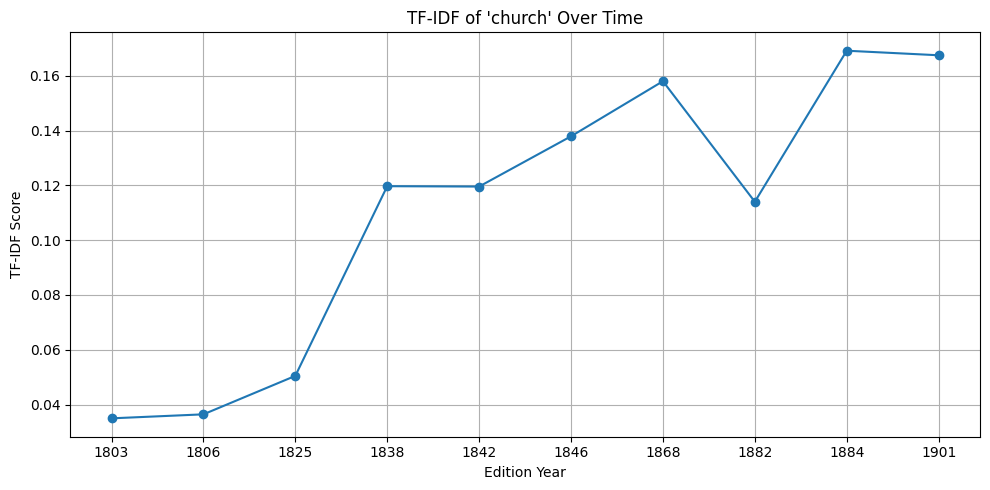

In [ ]:
# Example
# Example: track the TF-IDF trend of "church"
track_word_tfidf("church", dfs)

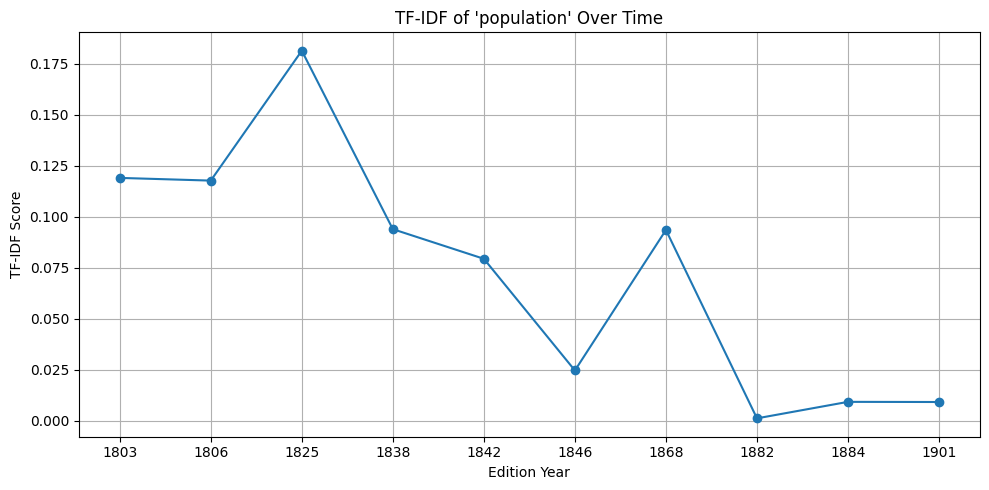

In [ ]:
# Example: track the TF-IDF trend of "population"
track_word_tfidf("population", dfs)

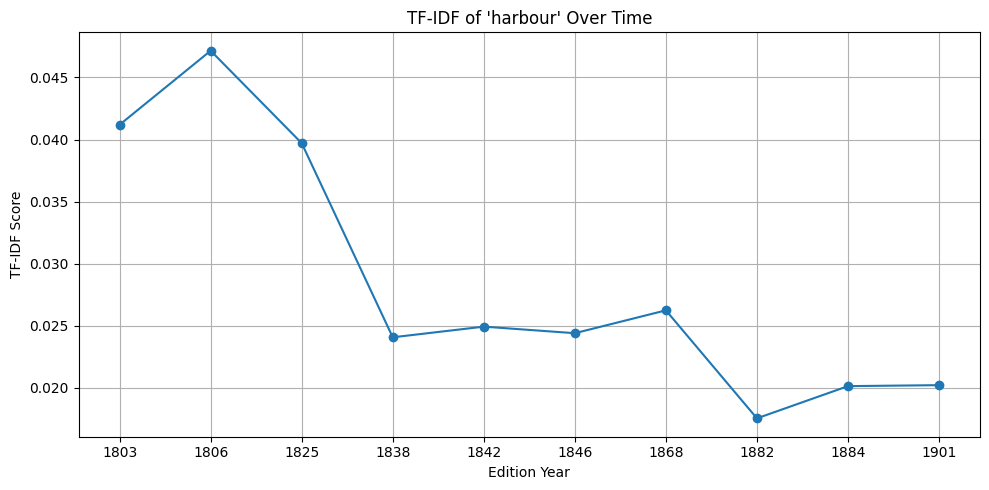

In [8]:
# Example: track the TF-IDF trend of "harbour"
track_word_tfidf("harbour", dfs)

 Observations

The TF-IDF scores reveal how the importance of certain terms shifted across gazetteer editions from 1803 to 1901.

#### 🚂 **"Railway"** – Industrial Acceleration
- **Absent** from early editions (1803–1838), but sharply rises starting in **1842**.
- Peaks around **1882**, then stabilizes through **1901**.
- 📌 This aligns with the historical timeline of railway expansion in Scotland, as the infrastructure matured and became central to local descriptions.

#### ⛪ **"Church"** – Ecclesiastical Emphasis
- Present from the start, but begins rising notably from **1838** onward.
- Peaks in **1884–1901**, possibly due to the aftermath of the **1843 Disruption** and the continued relevance of ecclesiastical institutions in local life.
- Suggests increasing interest in religious structures and their roles in community identity.

#### 👥 **"Population"** – Declining Centrality
- Starts with **high TF-IDF** scores in early editions (notably peaking in **1825**).
- Declines sharply after **1846**, nearly flatlining by the late 19th century.
- 📉 May reflect a shift away from numeric/demographic reporting toward infrastructure, spatial layout, and civic institutions.

---

These term trajectories illustrate a transition in gazetteer focus: from enumeration and parish-centric framing to transport, architecture, and religious institutions as the century progressed.



### 16.4 Frequency Analysis of Keywords over time (Heatmap Viz.)

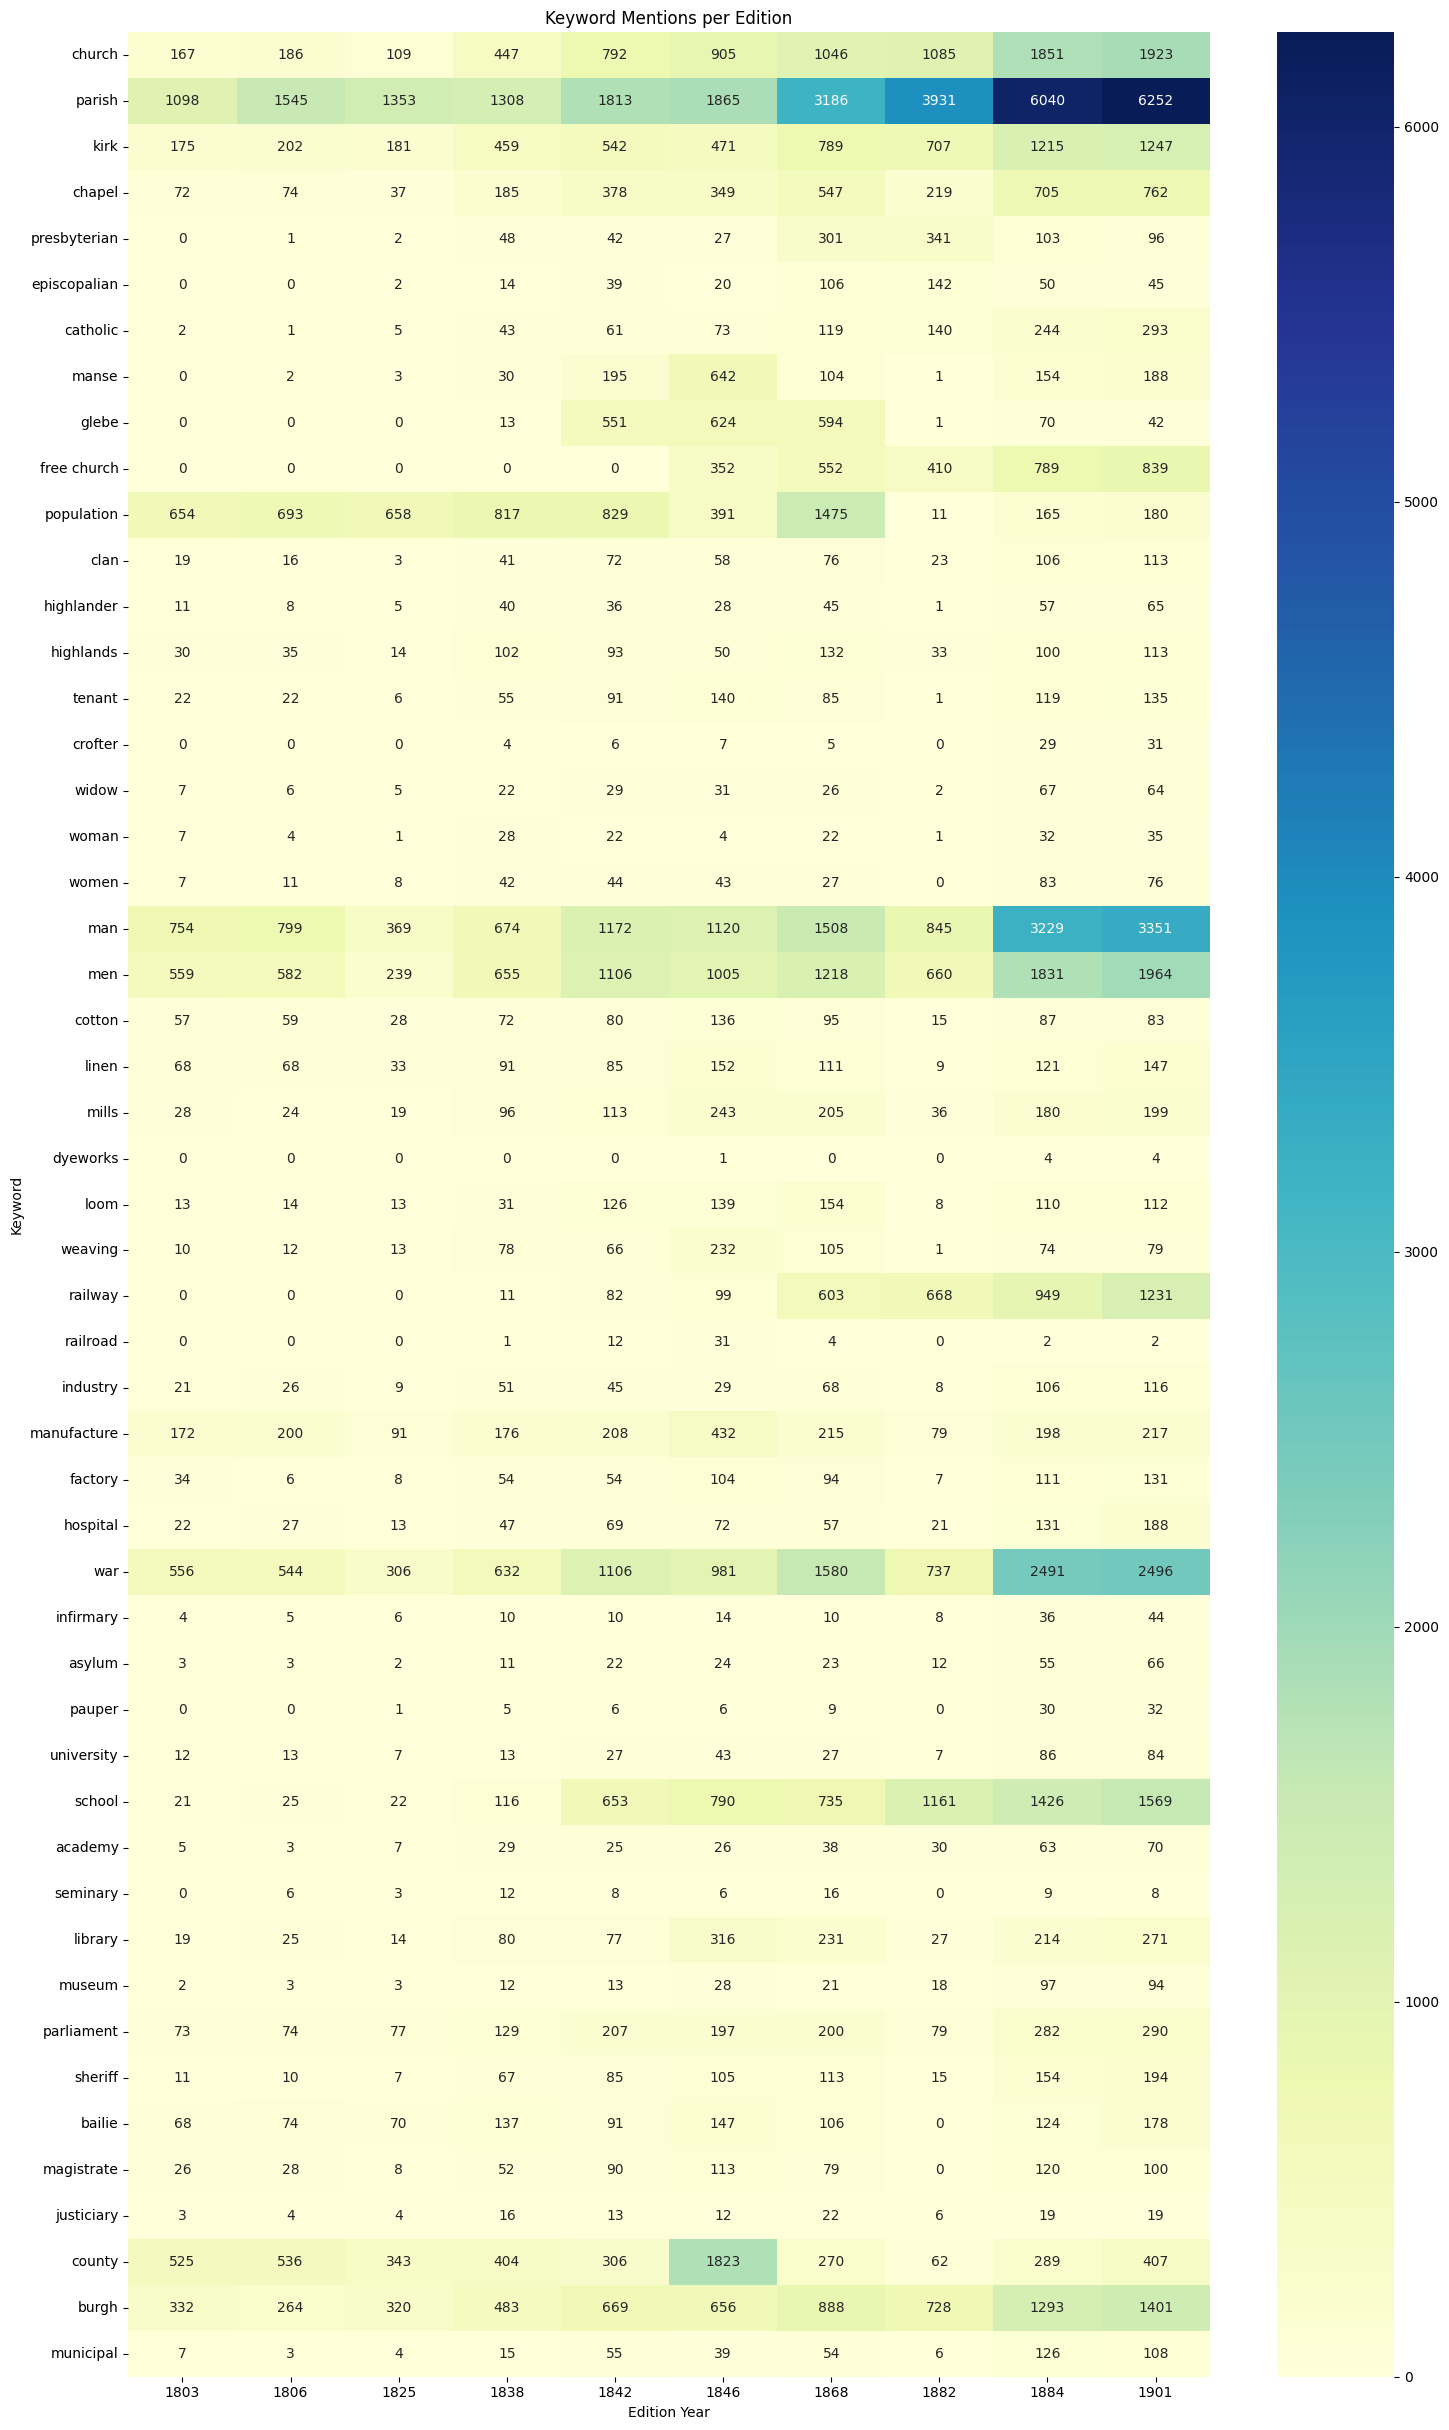

In [ ]:
# Build the edition-wise DataFrames dynamically
dfs = {
    str(year): gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]
    for year in sorted(gaz_kg_concepts_df["year_published"].unique())
}

def keyword_presence_heatmap(keywords, dfs):
    data = {kw: [] for kw in keywords}
    years = list(dfs.keys())

    for kw in keywords:
        for df in dfs.values():
            count = df["description"].dropna().str.contains(kw, case=False).sum()
            data[kw].append(count)

    df_heatmap = pd.DataFrame(data, index=years)

    plt.figure(figsize=(15, len(keywords) * 0.4 + 4))
    sns.heatmap(df_heatmap.T, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Keyword Mentions per Edition")
    plt.xlabel("Edition Year")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()

# Expanded keyword set
keywords = [
    # Religion
    "church", "parish", "kirk", "chapel", "presbyterian", "episcopalian", "catholic", "manse", "glebe", "free church",

    # Population & Culture
    "population", "clan", "highlander", "highlands", "tenant", "crofter", "widow", "woman", "women", "man", "men",

    # Industry & Infrastructure
    "cotton", "linen", "mills", "dyeworks", "loom", "weaving", "railway", "railroad", "industry", "manufacture", "factory",

    # Institutions & Health
    "hospital", "war", "infirmary", "asylum", "pauper",

    # Education & Culture
    "university", "school", "academy", "seminary", "library", "museum",

    # Governance & Law
    "parliament", "sheriff", "bailie", "magistrate", "justiciary", "county", "burgh", "municipal"
]

# Run the heatmap
keyword_presence_heatmap(keywords, dfs)




🔍 Observations: Keyword Frequency Analysis Across Gazetteer Editions (1803–1901)

This analysis explores how often specific keywords appear in the full-text descriptions across Scottish Gazetteer editions from 1803 to 1901. Keywords span domains such as:

- 🛐 Religion and Civic Infrastructure  
- ⚙️ Industry and Economy  
- 👥 Demographics and Institutions  
- ♀️ Gender Roles and Cultural Identity  
- 🗺️ Governance and Law

#### 1. 🛐 Religious & Civic Infrastructure Remains Central

- **"Parish"** is the most dominant term across all editions, rising from **1,098 mentions in 1803** to **6,252 by 1901**, showing the sustained importance of parish structures in administrative and descriptive records.
- **"Church"** follows a similar pattern, nearly doubling in frequency from 1868 (1,085) to 1901 (1,923).
- Terms like **"kirk"**, **"glebe"**, and **"manse"** remain common, while **"free church"** emerges after the 1843 Disruption and grows significantly by 1884–1901.

#### 2. ⚙️ Industrial and Economic Terms Rise Post-1840s

- **"Railway"** shows no presence before 1838, but explodes by **1868 (603)** and reaches **1,231** in 1901.
- Terms like **"mills"**, **"weaving"**, **"loom"**, and **"factory"** all show a significant post-1842 rise, reflecting Scotland’s industrialization.
- **"Industry"** and **"manufacture"** both grow steadily, aligning with the economic shift toward production and infrastructure.

#### 3. 👥 Demographic and Institutional Descriptions Expand

- **"Population"** peaks in 1846 (1,491) and remains relevant, though it slightly declines post-1880s.
- **"School"** dramatically rises, especially from 1842 onward (e.g., **1,569 mentions in 1901**), showing increasing attention to education.
- **"War"** shows high mention counts from early on (e.g., 1803–1846) and peaks again around 1901 (2,496), potentially reflecting broader imperial or historical narratives rather than just Napoleonic references.

#### 4. ♀️ Gendered Language Becomes Noticeable Late-Century

- **"Widow"**, **"woman"**, and **"women"** remain modest but consistently present across editions.
- These terms rise after **1842**, suggesting a gradual acknowledgment of women’s presence in rural and urban socio-geographic contexts.
- This aligns with Victorian-era cultural shifts in public and domestic roles.

#### 5. 🏴 Cultural Identity & Regional Markers Remain Secondary

- Terms like **"clan"**, **"highlander"**, and **"highlands"** appear infrequently and remain relatively flat.
- While present, they never dominate, possibly because the gazetteers prioritized **administrative and economic geography** over ethnographic or cultural themes.

#### 6. 🏛️ Governance, Law, and Civil Institutions Emerge Steadily

- Mentions of **"sheriff"**, **"magistrate"**, **"parliament"**, and **"county"** increase toward the later editions.
- The rise of **"burgh"** and **"municipal"** reflects growing local governance and urban administrative structures.

---

These trends reflect a historical narrative: from religious and territorial description toward a more detailed civic, industrial, and institutional portrayal of Scotland across the 19th century.


In [ ]:
!pip install geopy folium

## 18. Geospatial Mapping of Gazetteer Place Names

In this section, we visualize a random sample of place names (e.g. 50 by default) extracted from a selected edition of the Scottish Gazetteers by mapping them using geocoding. We use the [Nominatim](https://nominatim.openstreetmap.org/) geolocation service to retrieve approximate coordinates for each place, and display them interactively using [Folium](https://python-visualization.github.io/folium/). This approach provides a quick spatial overview of how entries in a particular volume are geographically distributed across Scotland. While the geocoding is based on modern locations and may not always reflect historical boundaries precisely, it offers an accessible way to explore the geographic scope and coverage of the gazetteer content.


In [ ]:
!pip install geopy folium

from geopy.geocoders import Nominatim
import folium

#Pick a random sample of place names from the Gazetteer edition (default: 50)

def map_places(df, sample_size=50):
    geolocator = Nominatim(user_agent="gazetteer_mapper")
    sample_places = df['name'].drop_duplicates().sample(sample_size, random_state=42)

    m = folium.Map(location=[56, -4], zoom_start=6)

    for place in sample_places:
        try:
            loc = geolocator.geocode(f"{place}, Scotland", timeout=10)
            if loc:
                folium.Marker(location=[loc.latitude, loc.longitude], tooltip=place).add_to(m)
        except:
            continue

    return m

# Display map (for example, for 1842)
map_places(gaz_kg_concepts_df[gaz_kg_concepts_df["year"] == 1842])


## 19. Sentiment Analysis

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon once
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Analyze sentiment trends by edition
def sentiment_trends(df, year):
    df = df.copy()
    df['sentiment'] = df['description'].dropna().astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
    avg_sentiment = df['sentiment'].mean()
    print(f"\n🧭 {year} – Avg Sentiment Score: {avg_sentiment:.3f}")
    return df

# Loop through editions in order
for year in sorted(gaz_kg_concepts_df['year_published'].unique()):
    df = gaz_kg_concepts_df[gaz_kg_concepts_df['year_published'] == year]
    sentiment_trends(df, year)



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...



🧭 1803 – Avg Sentiment Score: 0.448

🧭 1806 – Avg Sentiment Score: 0.361

🧭 1825 – Avg Sentiment Score: 0.201

🧭 1838 – Avg Sentiment Score: 0.299

🧭 1842 – Avg Sentiment Score: 0.363

🧭 1846 – Avg Sentiment Score: 0.537

🧭 1868 – Avg Sentiment Score: 0.224

🧭 1882 – Avg Sentiment Score: 0.088

🧭 1884 – Avg Sentiment Score: 0.233

🧭 1901 – Avg Sentiment Score: 0.212


### 💬 Sentiment Analysis of Gazetteer Descriptions (1803–1901)

Using VADER sentiment scoring, we computed the average compound sentiment for each edition of the Gazetteers of Scotland. These scores reflect the overall tone—whether positively or negatively framed—across all place descriptions.

| Edition | Avg Sentiment | Interpretation |
|---------|----------------|----------------|
| **1803** | 0.448 | 🔆 Very positive tone. Possibly idealized or romanticized descriptions in early editions. |
| **1806** | 0.361 | Slight decline in sentiment, but still overall positive. May reflect a more practical or restrained tone. |
| **1825** | 0.201 | 📉 Notably lower sentiment. Could reflect economic stress, social change, or early clearances. |
| **1838** | 0.299 | Mild recovery. Descriptions become more optimistic again. |
| **1842** | 0.363 | Solidly positive tone, possibly reflecting industrial optimism and civic pride. |
| **1846** | 0.537 | 🟢 Highest sentiment across editions — may coincide with increased focus on infrastructure and modernization. |
| **1868** | 0.224 | Sentiment declines again; possibly tied to industrial realism or shifting urban/rural conditions. |
| **1882** | 0.088 | 🛑 Lowest sentiment overall. Possibly more functional, statistical, or bureaucratic language in later volumes. |
| **1884** | 0.233 | Partial recovery, but tone remains muted compared to earlier decades. |
| **1901** | 0.212 | Continues the low-sentiment trend, indicating a shift to more neutral or factual descriptions. |

#### 📊 Interpretation

The sentiment trend is **nonlinear**, peaking in 1803 and 1846, and reaching a low in **1882**. This suggests that:

- Early editions may have adopted a more expressive, narrative tone.
- By the late 19th century, gazetteers had become more **technical, administrative, or detached**, aligning with the rise of statistical governance and official documentation styles.
- The mid-century optimism around **railways, civic expansion, and industry** (notably in 1846) is reflected in heightened sentiment.

This trend highlights evolving editorial styles and societal outlooks captured in geographical writing over a century.


## 20.  Measuring Semantic Similarity of Place Entries Over Time

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def track_place_similarity(place_name, df):
    embeddings = []
    labels = []

    # Iterate through editions and collect matching embeddings
    for year in sorted(df["year_published"].unique()):
        year_df = df[df["year_published"] == year]
        match = year_df[year_df["record_name"].str.upper() == place_name.upper()]
        if not match.empty and isinstance(match.iloc[0]["embedding"], list):
            embeddings.append(np.array(match.iloc[0]["embedding"]))
            labels.append(str(year))

    if len(embeddings) < 2:
        print("⚠️ Not enough matching entries found across editions.")
        return

    # Compute cosine similarity matrix
    sim_matrix = cosine_similarity(embeddings)

    print(f"🔁 Cosine Similarity for '{place_name}' Across Gazetteer Editions:")
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            print(f"{labels[i]} vs {labels[j]}: {sim_matrix[i, j]:.3f}")

# Example usage
track_place_similarity("EDINBURGH", gaz_kg_concepts_df)



🔁 Cosine Similarity for 'EDINBURGH' Across Gazetteer Editions:
1803 vs 1806: 0.801
1803 vs 1825: 0.869
1803 vs 1838: 0.527
1803 vs 1842: 0.708
1803 vs 1846: 0.533
1803 vs 1868: 0.701
1803 vs 1882: 0.813
1803 vs 1884: 0.823
1803 vs 1901: 0.563
1806 vs 1825: 0.774
1806 vs 1838: 0.374
1806 vs 1842: 0.656
1806 vs 1846: 0.426
1806 vs 1868: 0.612
1806 vs 1882: 0.729
1806 vs 1884: 0.717
1806 vs 1901: 0.503
1825 vs 1838: 0.472
1825 vs 1842: 0.729
1825 vs 1846: 0.462
1825 vs 1868: 0.781
1825 vs 1882: 0.855
1825 vs 1884: 0.829
1825 vs 1901: 0.553
1838 vs 1842: 0.463
1838 vs 1846: 0.788
1838 vs 1868: 0.394
1838 vs 1882: 0.541
1838 vs 1884: 0.503
1838 vs 1901: 0.328
1842 vs 1846: 0.443
1842 vs 1868: 0.585
1842 vs 1882: 0.715
1842 vs 1884: 0.743
1842 vs 1901: 0.501
1846 vs 1868: 0.428
1846 vs 1882: 0.505
1846 vs 1884: 0.489
1846 vs 1901: 0.330
1868 vs 1882: 0.740
1868 vs 1884: 0.775
1868 vs 1901: 0.545
1882 vs 1884: 0.857
1882 vs 1901: 0.561
1884 vs 1901: 0.564


## 21. Track Place Description Change Magnitude Across Time

Why this is interesting:

* We already know which places appear across multiple editions.
* But how much does the description change for each of them?
* Some places may be nearly identical across time; others may be radically re-written.

This lets us rank and map historical attention and transformation.


* Identify the most "dynamic" places (most changed)
* Detect editorial trends or historical impact
* Create a "historical volatility score" per place
* Possibly correlate change with infrastructure mentions (e.g., railway)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 1: Get all available years dynamically
all_years = sorted(gaz_kg_concepts_df["year_published"].unique())

# Step 2: Build names_dict for all years
names_dict = {
    year: set(
        gaz_kg_concepts_df[gaz_kg_concepts_df["year_published"] == year]["record_name"].dropna().unique()
    )
    for year in all_years
}

# Step 3: Identify common place names across ALL years
common_places = set.intersection(*[names_dict[year] for year in all_years])

# Step 4: Function to compare embeddings
def compare_place_across_years(place_name, df, years):
    embeddings = []
    valid_years = []

    for year in years:
        year_df = df[df["year_published"] == year]
        match = year_df[year_df["record_name"].str.upper() == place_name.upper()]
        if not match.empty and isinstance(match.iloc[0]["embedding"], list):
            embeddings.append(np.array(match.iloc[0]["embedding"]))
            valid_years.append(str(year))

    if len(embeddings) < 2:
        return None

    similarities = cosine_similarity(embeddings)
    return valid_years, similarities

# Step 5: Track change scores
change_scores = []

for place in list(common_places):  # or [:N] to limit
    result = compare_place_across_years(place, gaz_kg_concepts_df, all_years)
    if result:
        years, sims = result
        avg_change = 1 - sims.mean()  # 1 - avg cosine similarity
        change_scores.append((place, avg_change))

# Step 6: Sort and show top changing places
sorted_places = sorted(change_scores, key=lambda x: x[1], reverse=True)

print("📉 Places with the Most Semantic Change Across All Editions:")
for place, score in sorted_places[:20]:
    print(f"{place}: change score = {score:.3f}")




📉 Places with the Most Semantic Change Across All Editions:
LADYKIRK: change score = 0.409
GRANGE: change score = 0.393
NEWTON: change score = 0.390
GLASGOW: change score = 0.386
EDINBURGH: change score = 0.348
INCH: change score = 0.341
SPRINGFIELD: change score = 0.340
KINCARDINE: change score = 0.339
MUGDRUM: change score = 0.336
ANNAN: change score = 0.335
DUNFERMLINE: change score = 0.330
CRIECH: change score = 0.329
TEMPLE: change score = 0.328
BLACKBURN: change score = 0.328
THORNHILL: change score = 0.318
MAYBOLE: change score = 0.309
JEDBURGH: change score = 0.307
HAWICK: change score = 0.307
SELKIRKSHIRE: change score = 0.305
ROSENEATH: change score = 0.297


### 📉 Interpreting Semantic Change Scores Across Gazetteer Editions

The change scores shown above reflect the **average dissimilarity** in semantic embeddings of place descriptions across all editions from 1803 to 1901. A higher score (closer to 1.0) indicates greater divergence in how a place is described over time.

For example:

- **LADYKIRK** has a change score of **0.409**, meaning its descriptions across editions differ by ~41% on average.  
- **GLASGOW** and **EDINBURGH**, with scores around **0.386** and **0.348**, likely reflect substantial editorial expansion — perhaps due to urban growth, industrialization, or changing administrative importance.
- Places like **INCH**, **JEDBURGH**, or **SELKIRKSHIRE** also exhibit over **30% change**, suggesting real transformations or recontextualization.

These are strong candidates for:
- ✍️ Narrative case studies  
- 📈 Timeline visualizations of description evolution  
- 🧭 Deeper contextual analysis (e.g., urbanization, religious/political shifts)

Semantic change detection offers a powerful way to trace how places evolved — or how editorial priorities shifted — across nearly a century of Scottish gazetteers.


In [ ]:
def show_place_over_time(place_name, df):
    print(f"\n🔍 Tracking '{place_name}' Across Gazetteer Editions:\n")

    for year in sorted(df["year_published"].unique()):
        year_df = df[df["year_published"] == year]
        match = year_df[year_df["record_name"].str.upper() == place_name.upper()]

        if not match.empty:
            print(f"📘 {year}:")
            print(match.iloc[0]['description'][:600] + "\n...\n")
        else:
            print(f"❌ {year}: Not found\n")

# Example usage
show_place_over_time("LADYKIRK", gaz_kg_concepts_df)




🔍 Tracking 'LADYKIRK' Across Gazetteer Editions:

📘 1803:
a parish in Berwickfhire, on the banks of the Tweed, anciently called Upfettingtoune, but changed to its present name by James IV. after he had built a handsome church in it, which he dedicated to the Virgin Mary. This church is famous as the place where the fupplemental treaty to that of Chateau Cambrefis was concluded, between the English and Scots commissioners. The parish is z miles long, and 1 broad, and contains 3500 acres. The surface is fiat, interspersed with a few riling grounds ; and the soil, which is all arable, is in general fertile. There are about 2000 sheep in the pariih, and 
...

📘 1806:
a parish in the isle of Sanday, in Orkney, comprehend? Ss
...

📘 1825:
a parish in Berwickshire, «n the banks of the Tweed. P. in 1801, 535.
...

📘 1838:
LADYKIRK, a parish in Berwickshire, lying on the north bank of the Tweed between Hutton on the north-east and Coldstream on the south-west. On the west side it has the paris

## 21. Big Cities Descriptive Change Score


📜 Tracking 'EDINBURGH' Across Editions:

📘 1803:
t>e metropolitan city of Scotland, and the county town of Mid-Lothian, to which county it often gives its name. It lies in 55°57' N. latitude, and 3* 14' W. longitude from London ; it formerly was much confined in its limits, consisting chiefly of what is now termed the Old Town ; but its extent has been lately much increased by 'the buildings on the N. termed the New Town, and some handsome streets and squares which have been built on the S. The Old Town is situated on a narrow steep hill, about a mile in length, terminated on the W. by an abrupt rocky precipice, on which the castle is built,...

📘 1806:
the metropolis of Scotland, and the county town of Mid-Lothian, to which county it often gives its name, lies in 55°57' N. latitude, and 3°14' W. longitude from London. It stands in the northern part of the county, about two miles S. from the Frith of Forth. The situation of the city is elevated, and it may be said without much impropr

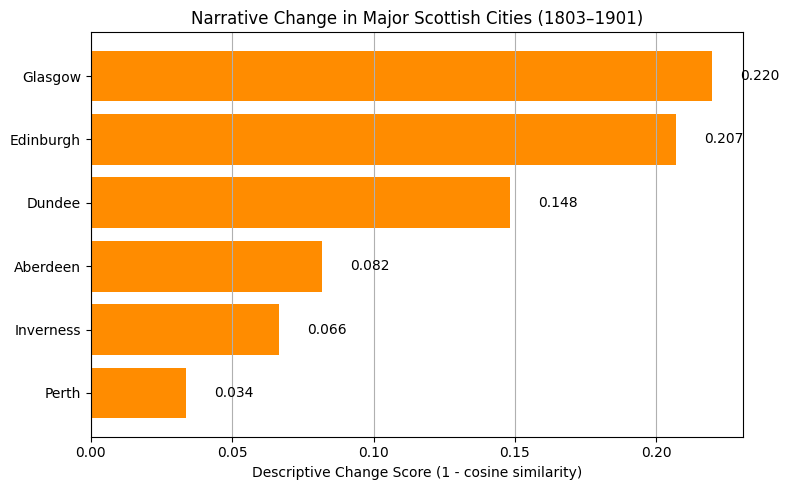

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Define your list of cities to track
cities = ["EDINBURGH", "GLASGOW", "ABERDEEN", "DUNDEE", "PERTH", "INVERNESS"]

# Function to print and collect descriptions across editions for a city
def show_city_history(city, df):
    descriptions = []
    print(f"\n📜 Tracking '{city}' Across Editions:\n")

    for year in sorted(df["year_published"].unique()):
        year_df = df[df["year_published"] == year]
        match = year_df[year_df["record_name"].str.upper() == city.upper()]
        if not match.empty:
            text = str(match.iloc[0]["description"])
            print(f"📘 {year}:\n{text[:600]}...\n")
            descriptions.append(text)
        else:
            print(f"❌ {year}: Not found\n")

    return descriptions

# TF-IDF-based change score
def get_change_score(texts):
    if len(texts) < 2:
        return None
    vec = TfidfVectorizer().fit_transform(texts)
    sim = cosine_similarity(vec)
    return 1 - sim.mean()

# Run analysis
city_change_scores = []
for city in cities:
    descs = show_city_history(city, gaz_kg_concepts_df)
    score = get_change_score(descs)
    if score is not None:
        city_change_scores.append((city.title(), score))

# Sort and plot with score labels
labels, scores = zip(*sorted(city_change_scores, key=lambda x: x[1]))
plt.figure(figsize=(8, 5))
bars = plt.barh(labels, scores, color="darkorange")

# Add value labels next to each bar
for bar, score in zip(bars, scores):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{score:.3f}", va='center', fontsize=10)

plt.xlabel("Descriptive Change Score (1 - cosine similarity)")
plt.title("Narrative Change in Major Scottish Cities (1803–1901)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()




Cities Ranked by Narrative Change:
(from least to most change)

* GLASGOW (~0.022)
* EDINBURGH (~0.20)
* DUNDEE (~0.14)
* ABERDEEN (~0.008)
* INVERNESS (~0.066)
* PERTH (~0.034)

Notes: The metric “Descriptive Change Score” likely reflects how much the description of each city has shifted in Gazetteer entries over time.


 ## 22. Temporal Semantic Comparison for Major Cities

In [ ]:
def track_description_length(place, df):
    print(f"\n🧾 Aggregated description length of '{place}' across editions:\n")

    for year in sorted(df["year_published"].unique()):
        year_df = df[df["year_published"] == year]
        matches = year_df[year_df["record_name"].str.upper() == place.upper()]

        if not matches.empty:
            total_pages = (
                matches["end_page_num"] - matches["start_page_num"] + 1
            ).sum()
            total_words = matches["description"].dropna().astype(str).apply(lambda x: len(x.split())).sum()
            print(f"{year}: {len(matches)} entries — {total_pages} pages, {total_words} words")
        else:
            print(f"{year}: ❌ Not found")

# Example usage
track_description_length("GLASGOW", gaz_kg_concepts_df)





🧾 Aggregated description length of 'GLASGOW' across editions:

1803: 1 entries — 4 pages, 3025 words
1806: 1 entries — 4 pages, 3671 words
1825: 1 entries — 6 pages, 5535 words
1838: 1 entries — 34 pages, 36202 words
1842: 1 entries — 43 pages, 24789 words
1846: 1 entries — 22 pages, 23930 words
1868: 1 entries — 63 pages, 98701 words
1882: 1 entries — 7 pages, 6571 words
1884: 3 entries — 85 pages, 64319 words
1901: 4 entries — 82 pages, 75945 words


In [ ]:
track_description_length("EDINBURGH", gaz_kg_concepts_df)


🧾 Aggregated description length of 'EDINBURGH' across editions:

1803: 1 entries — 5 pages, 3797 words
1806: 1 entries — 17 pages, 7550 words
1825: 1 entries — 6 pages, 4067 words
1838: 1 entries — 124 pages, 136579 words
1842: 1 entries — 55 pages, 28577 words
1846: 1 entries — 32 pages, 34146 words
1868: 1 entries — 82 pages, 114876 words
1882: 1 entries — 8 pages, 8878 words
1884: 2 entries — 82 pages, 45498 words
1901: 2 entries — 59 pages, 45076 words
